# Figure 6: MACM Figures for main paper and connected supplementary information.

## We show the meta-analytic conenctivity modeling (MACM) results for behavioral (sub)domains that had 15 or more experiments with foci within the converging (p < .001 and k = 50) C-SALE cluster.
### Author: Neville Magielse
#### Date: 12.08.2024

In [1]:
import os
import sys

# User-specified base working directory
BASE_DIR = '/data/project/cerebellum_ale/'  # Change this to your project folder. Make sure they have input and output folders.

# Defines input and output paths.
INPUT_DIR = os.path.join(BASE_DIR, 'input')
OUTPUT_DIR = os.path.join(BASE_DIR, 'output')

sys.path.append(os.path.join(BASE_DIR, 'scripts'))

In [2]:
import nimare
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.patches import Patch
import matplotlib.patches as mpatches
import seaborn as sns
import nilearn.plotting, nilearn.maskers, nilearn.image
from nilearn.plotting import plot_roi
import nilearn.surface
import nibabel

from pprint import pprint
import itertools
import scipy
import scipy.spatial
from tqdm import tqdm

import nimare_gpu
import SUITPy.flatmap
import neuromaps
import brainspace.mesh, brainspace.plotting
import hcp_utils as hcp

import scipy.cluster.hierarchy as sch

import pyvirtualdisplay
import tempfile

from nimare.meta.cbma.ale import ALE, SCALE
from nimare.utils import vox2mm, mm2vox
from nimare_gpu.ale import DeviceALE, DeviceSCALE, DeviceMixin
from nimare.correct import FWECorrector
import argparse
from numba import cuda
import json
import glob
import warnings
warnings.simplefilter('ignore')

import neuromaps
import neuromaps.nulls

from itertools import islice

plt.rcParams.update({'font.size': 16, "font.family": "Asana Math", "figure.dpi": 192})


# plt.rcParams['text.usetex'] = False

pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


In [3]:
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

# Define the RGB values for dark red corresponding to hex color #d41e1e
# rgb_color = (212/255, 30/255, 30/255)  # RGB values for dark red
rgb_color = (170/255, 0/255, 34/255)  # RGB values for darker burgundy

# Create a custom colormap with two identical colors (using the RGB tuple)
colors = [rgb_color, rgb_color]

# Create the custom colormap
custom_cmap = LinearSegmentedColormap.from_list('custom_cmap', colors)

In [4]:
# Only list valid Domains (N >15 in ../output/macm_exp_stats_from_json_240814.csv)
domains = ['Action']

In [5]:
# Only list valid Subdomains (N >15 in ../output/macm_exp_stats_from_json_240814.csv)
subdomains = ['Execution', 'Execution.Speech', 'Memory.Working', 'Vision']


In [6]:
subdomains_exps = {'Execution': 251,
                   'Execution.Speech': 80, 
                   'Memory.Working': 21,
                   'Vision': 34}

In [7]:
subdomain_labels = pd.Series({
    'Action': 'Action',
    'Action.Execution': 'Execution',
    'Action.Execution.Speech': 'Speech Execution',
    'Cognition.Memory.Working': 'Working Memory',
    'Perception.Vision': 'Vision'
})

In [8]:
# Define required functions

def plot_surface(surface_data, mesh, itype=None, filename=None, 
        layout_style='row', cmap='viridis', vrange=None, cbar=False,
        nan_color=(0.75, 0.75, 0.75, 1), **plotter_kwargs):
    """
    Plots `surface_data` on `mesh` using brainspace

    Parameters
    ----------
    surface_data: (np.ndarray)
    mesh: (str | dict)
        - fsaverage
        - fsaverage5
        - dict of path to meshes for 'L' and 'R'
    itype: (str | None)
        mesh file type. For .gii enter None. For freesurfer files enter 'fs'
    filename: (Pathlike str)
    layout_style: (str)
        - row
        - grid
    cmap: (str)
    vrange: (tuple | None)
    nan_color: (tuple)
    **plotter_kwargs
    """
    # create virtual display for plotting in remote servers
    disp=pyvirtualdisplay.Display(visible=False)
    disp.start()
    # load surface mesh
    if isinstance(mesh, str):
        if mesh in ['fsaverage', 'fsaverage5']:
            mesh = {
                'L': nilearn.datasets.fetch_surf_fsaverage(mesh)['infl_left'],
                'R': nilearn.datasets.fetch_surf_fsaverage(mesh)['infl_right'],
            }
            itype = None
        else:
            raise ValueError("Unknown mesh")
    else:
        for fs_suffix in ['.pial', '.midthickness', '.white', '.inflated']:
            if mesh['L'].endswith(fs_suffix):
                itype = 'fs'
    if not os.path.exists(mesh['L']):
        raise ValueError("Mesh not found")
    lh_surf = brainspace.mesh.mesh_io.read_surface(mesh['L'], itype=itype)
    rh_surf = brainspace.mesh.mesh_io.read_surface(mesh['R'], itype=itype)
    # configurations
    if filename:
        screenshot = True
        embed_nb = False
        filename += '.png'
    else:
        screenshot = False
        embed_nb = True
    if layout_style == 'row':
        size = (1600, 400)
        zoom = 1.2
    else:
        size = (900, 500)
        zoom = 1.8
    if vrange is None:        
        vrange = (np.nanmin(surface_data), np.nanmax(surface_data))
    elif vrange == 'sym':
        vmin = min(np.nanmin(surface_data), -np.nanmax(surface_data))
        vrange = (vmin, -vmin)
    if cbar:
        plot_colorbar(vrange[0], vrange[1], cmap)
    return brainspace.plotting.surface_plotting.plot_hemispheres(
        lh_surf, rh_surf, 
        surface_data,
        layout_style = layout_style,
        cmap = cmap, color_range=vrange,
        # TODO: change size and zoom based on layout 
        size=size, zoom=zoom,
        interactive=False, embed_nb=embed_nb,
        screenshot=screenshot, filename=filename, 
        transparent_bg=True,
        nan_color=nan_color,
        **plotter_kwargs
        )

def mni_get_subcortex(nifti):
    subcortex_mask = nilearn.image.binarize_img(
        os.path.join(INPUT_DIR, 'maps', 'Tian_Subcortex_S1_3T.nii')
    )
    subcortex_array = nilearn.masking.apply_mask(nifti, subcortex_mask)
    subcortex_img = nilearn.masking.unmask(subcortex_array, subcortex_mask)
    return subcortex_img

def plot_parc_subcortical(parc_data, schaefer=400, tian='S2', nan_zero=True,
                          zoom=1.3, size=(1200,300),
                          color_range='whole-brain', **plotter_kwargs):
    ## THIS DOESN'T WORK
    # create virtual display for plotting in remote servers
    disp=pyvirtualdisplay.Display(visible=False)
    disp.start()
    # get translation map from tian to the 14 structures expected
    # by enigmatoolbox plotter
    if tian == 'S1':
        atlas_cifti = nibabel.load(
            os.path.join(INPUT_DIR, 'maps', f'Schaefer2018_{schaefer}Parcels_7Networks_order_Tian_Subcortex_S1.dlabel.nii')
        )
        labels = [l.label for i, l in list(atlas_cifti.header.get_index_map(0)._maps[0].label_table.items())[1:]]
    else:
        with open(
            os.path.join(INPUT_DIR, 'maps', f'Schaefer2018_{schaefer}Parcels_7Networks_order_Tian_Subcortex_{tian}_label.txt'),
            'r'
        ) as f:
            labels = f.read().split('\n')
            labels = labels[:-1:2]
    subcortical_labels = np.where(~pd.Series(labels).str.contains('7Networks'))
    subcortical_labels = np.array(labels)[subcortical_labels]
    tian_to_mesh = pd.Series(index=subcortical_labels)
    abbr_to_full = {
        'HIP': 'Hippocampus',
        'AMY': 'Amygdala',
        'THA': 'Thalamus',
        'NAc': 'Accumbens',
        'GP': 'Pallidum',
        'PUT': 'Putamen',
        'CAU': 'Caudate'
    }
    for label in subcortical_labels:
        hem = 'Left' if '-lh' in label else 'Right'
        for key in abbr_to_full:
            if key in label:
                tian_to_mesh.loc[label] = f'{hem} {abbr_to_full[key]}'
    # convert parcellated data from Tian to the 14 structures by averaging
    subcortex_plot_order = [
        'Left Accumbens', 'Left Amygdala', 'Left Caudate', 'Left Hippocampus', 
        'Left Pallidum', 'Left Putamen', 'Left Thalamus',
        'Right Accumbens', 'Right Amygdala', 'Right Caudate', 'Right Hippocampus', 
        'Right Pallidum', 'Right Putamen', 'Right Thalamus'
    ]
    plot_data = pd.DataFrame({'data': parc_data.loc[subcortical_labels], 'mesh_name': tian_to_mesh})
    plot_data = plot_data.groupby('mesh_name').mean().loc[subcortex_plot_order]
    if nan_zero:
        plot_data[plot_data==0] = np.NaN # this makes the plot nicer, matching the cortical plot
    # if indicated match color range of the whole brain
    if color_range == 'whole-brain':
        color_range = (np.nanmin(parc_data.values), np.nanmax(parc_data.values))
    print(plot_data)
    # plot
    return plot_subcortical(plot_data.values.flatten(), ventricles=False,
                     size=size, zoom=zoom, color_range=color_range,
                     color_bar=False, embed_nb=True, **plotter_kwargs)


def parcellate_volumetric(img_path, schaefer='400', tian='S2', nonzero=False):
    """
    Parcellated volumetric image
    """
    if nonzero:
        masker = NiftiLabelsMasker(
            os.path.join(INPUT_DIR, 'maps',
                f'Schaefer2018_{schaefer}Parcels_7Networks_order_Tian_Subcortex_{tian}_MNI152NLin6Asym_2mm.nii.gz'),
            strategy='sum',
            resampling_target='data',
            background_label=0
        )
        #>> count the number of non-zero voxels per parcel so the average
        # is calculated only among non-zero voxels
        nonzero_mask = nilearn.image.math_img('img != 0', img=img_path)
        nonzero_voxels_count_per_parcel = masker.fit_transform(nonzero_mask).flatten()
        #>> take the average of PET values across non-zero voxels
        img_parcel_sum = masker.fit_transform(img_path).flatten()
        parcellated_data = img_parcel_sum / nonzero_voxels_count_per_parcel
    else:
        masker = NiftiLabelsMasker(
            os.path.join(INPUT_DIR, 'maps',
                f'Schaefer2018_{schaefer}Parcels_7Networks_order_Tian_Subcortex_{tian}_MNI152NLin6Asym_2mm.nii.gz'),
            strategy='mean',
            resampling_target='data',
            background_label=0)
        parcellated_data = masker.fit_transform(img_path).flatten()
    # get labels excluding background
    if tian == 'S1':
        atlas_cifti = nibabel.load(
            os.path.join(INPUT_DIR, 'maps', 
                         f'Schaefer2018_{schaefer}Parcels_7Networks_order_Tian_Subcortex_S1.dlabel.nii')
        )
        labels = [l.label for i, l in list(atlas_cifti.header.get_index_map(0)._maps[0].label_table.items())[1:]]
    else:
        with open(
            os.path.join(INPUT_DIR, 'maps', 
                         f'Schaefer2018_{schaefer}Parcels_7Networks_order_Tian_Subcortex_{tian}_label.txt'
                ), 'r') as f:
            labels = f.read().split('\n')
            labels = labels[:-1:2]
    # add labels of the parcels
    parcellated_data = pd.Series(
        parcellated_data,
        index = labels
    )

    return parcellated_data

# Example data

In [9]:
macm_nifti = os.path.join(OUTPUT_DIR, 'SALE/Action/Action/corr_cluster_h-001_k-50_mask-D2009_MNI_z_macm/corr_cluster_k-50_z.nii.gz') # Action BD-level.
macm_bin = nilearn.image.binarize_img(macm_nifti)

# For the cerebral cortex plots, we need to get the surface

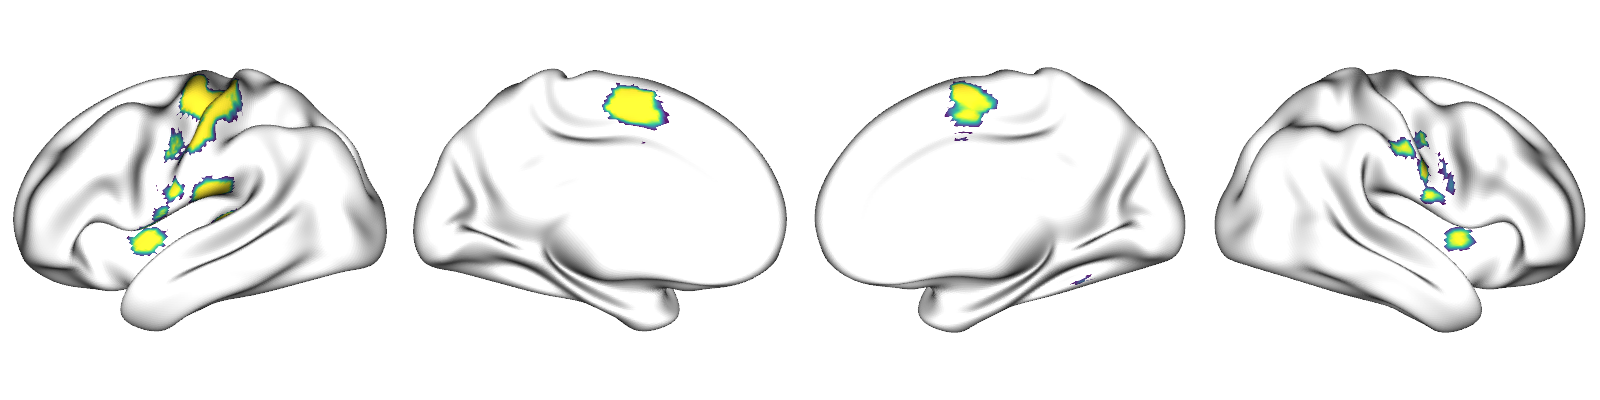

In [10]:
# macm_nift_figure = path.to.yourfigure
macm_fslr = neuromaps.transforms.mni152_to_fslr(macm_nifti, method='linear')
macm_fslr = np.concatenate([macm_fslr[0].agg_data(), macm_fslr[1].agg_data()])
macm_fslr[np.isclose(macm_fslr, 0)] = np.NaN
meshes_fslr = {'L': str(neuromaps.datasets.fetch_fslr()['inflated'].L), 
               'R': str(neuromaps.datasets.fetch_fslr()['inflated'].R)}
plot_surface(macm_fslr, meshes_fslr, cmap='viridis', nan_color=(1, 1, 1, 1))
# plot_surface(macm_fslr, meshes_fslr, filename = macm_nifti_figure, cmap='viridis', nan_color=(1, 1, 1, 1))

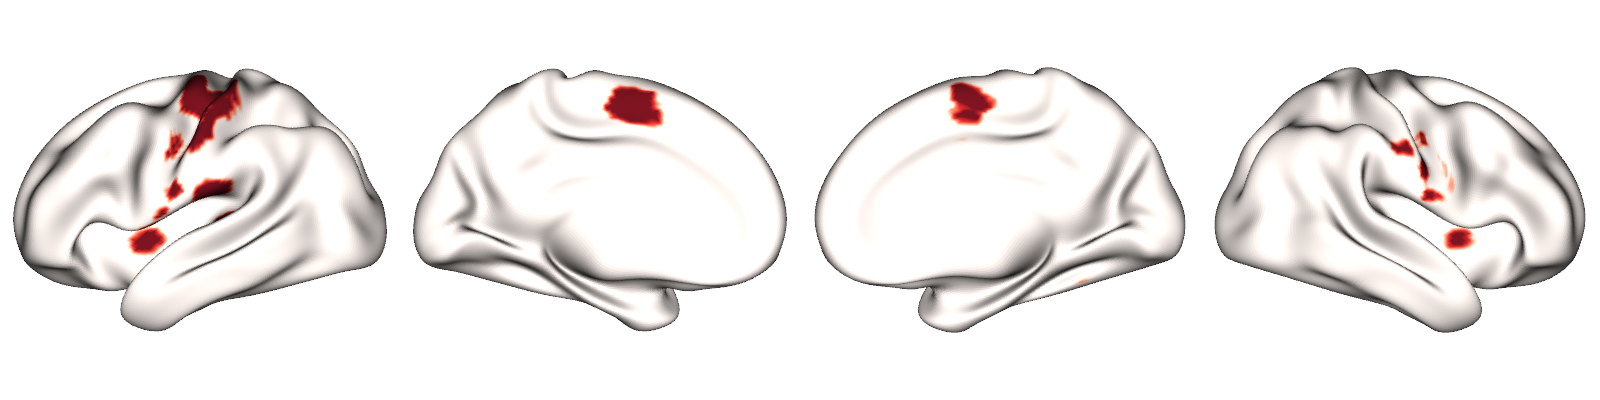

In [11]:
tmp_filename = tempfile.mktemp('.nii.gz')
macm_bin.to_filename(tmp_filename)
macm_bin_fslr = neuromaps.transforms.mni152_to_fslr(tmp_filename, method='linear')
macm_bin_fslr = np.concatenate([macm_bin_fslr[0].agg_data(), macm_bin_fslr[1].agg_data()])
meshes_fslr = {'L': str(neuromaps.datasets.fetch_fslr()['inflated'].L), 
               'R': str(neuromaps.datasets.fetch_fslr()['inflated'].R)}
plot_surface(macm_bin_fslr, meshes_fslr, cmap='Reds', nan_color=(0.65, 0.65, 0.65, 1.0))

# Plot the cerebral cortex for all MACM analyses
## Domains first

In [12]:
# Binarized Z-values of thesholded maps

from IPython.display import display

# List of domains
domains = ['Action']

# We fetch the FSLR meshes outside of the loop (they should be the same brain for each domain)
meshes_fslr = {'L': str(neuromaps.datasets.fetch_fslr()['inflated'].L), 
                       'R': str(neuromaps.datasets.fetch_fslr()['inflated'].R)}

# Iterate over each domain and construct file paths
for domain in domains:
    # Construct the file path for the current domain
    macm_nifti = os.path.join(OUTPUT_DIR, f'SALE/{domain}/{domain}/corr_cluster_h-001_k-50_mask-D2009_MNI_z_macm/corr_cluster_k-50_z.nii.gz')
    
    # Check if the file path exists
    if os.path.exists(macm_nifti):
        macm_bin = nilearn.image.binarize_img(macm_nifti)
        macm_bin_figure = os.path.join(BASE_DIR, f'Figures/Publication/Figure6/Cerebrum/{domain}/{domain}_MACM_Cerebral-Cortex-Surface_p001_K50-binarized')
        tmp_filename = tempfile.mktemp('.nii.gz')
        macm_bin.to_filename(tmp_filename)
        macm_bin_fslr = neuromaps.transforms.mni152_to_fslr(tmp_filename, method='linear')
        macm_bin_fslr = np.concatenate([macm_bin_fslr[0].agg_data(), macm_bin_fslr[1].agg_data()])
        
        display(plot_surface(macm_bin_fslr, meshes_fslr, filename= macm_bin_figure, cmap='Reds', nan_color=(1, 1, 1, 1)))
    
    else:
        print(f"File path does not exist for domain: {domain}. Skipping...")

'/data/project/cerebellum_ale/Figures/Publication/Figure6/Cerebrum/Action/Action_MACM_Cerebral-Cortex-Surface_p001_K50-binarized.png'

In [13]:
# Binarized Z-values of unthesholded maps

from IPython.display import display

# List of domains
domains = ['Action']

# We fetch the FSLR meshes outside of the loop (they should be the same brain for each domain)
meshes_fslr = {'L': str(neuromaps.datasets.fetch_fslr()['inflated'].L), 
                       'R': str(neuromaps.datasets.fetch_fslr()['inflated'].R)}

# Iterate over each domain and construct file paths
for domain in domains:
    # Construct the file path for the current domain
    macm_nifti = os.path.join(OUTPUT_DIR, f'SALE/{domain}/{domain}/corr_cluster_h-001_k-50_mask-D2009_MNI_z_macm/uncorr_z.nii.gz')
    
    # Check if the file path exists
    if os.path.exists(macm_nifti):
        macm_bin = nilearn.image.binarize_img(macm_nifti)
        macm_bin_figure = os.path.join(BASE_DIR, f'Figures/Publication/Figure6/Cerebrum/{domain}/{domain}_MACM_Cerebral-Cortex-Surface-binarized_unthres')
        tmp_filename = tempfile.mktemp('.nii.gz')
        macm_bin.to_filename(tmp_filename)
        macm_bin_fslr = neuromaps.transforms.mni152_to_fslr(tmp_filename, method='linear')
        macm_bin_fslr = np.concatenate([macm_bin_fslr[0].agg_data(), macm_bin_fslr[1].agg_data()])
        
        display(plot_surface(macm_bin_fslr, meshes_fslr, filename= macm_bin_figure, cmap='Reds', nan_color=(1, 1, 1, 1)))
    
    else:
        print(f"File path does not exist for domain: {domain}. Skipping...")

'/data/project/cerebellum_ale/Figures/Publication/Figure6/Cerebrum/Action/Action_MACM_Cerebral-Cortex-Surface-binarized_unthres.png'

In [14]:
all_domains = ['Action', 'Cognition', 'Emotion', 'Interoception', 'Perception'] # We manually specify the domains here, to make sure all valid subdomains are added regardless of whether the BD was valid.

# Then, subdomains

In [15]:
# Thresholded (Binarized)
from IPython.display import display
meshes_fslr = {
    'L': str(neuromaps.datasets.fetch_fslr()['inflated'].L), 
    'R': str(neuromaps.datasets.fetch_fslr()['inflated'].R)
}

# Base directory for saving figures
base_figure_dir = os.path.join(BASE_DIR, 'Figures/Publication/Figure6/Cerebrum')

# Iterate over each subdomain and construct file paths
for subdomain in subdomains:
    for domain in all_domains: # We specify the full list of domains here, to make sure all valid subdomains are added regardless of whether the BD was valid.
        # Construct the file path for the current domain and subdomain
        macm_nifti = os.path.join(OUTPUT_DIR, f'SALE/{domain}/{domain}.{subdomain}/corr_cluster_h-001_k-50_mask-D2009_MNI_z_macm/corr_cluster_k-50_z.nii.gz')
        
        # Check if the file path exists
        if os.path.exists(macm_nifti):
            # Create the directory for saving the figure
            figure_dir = os.path.join(base_figure_dir, f'{domain}.{subdomain}')
            os.makedirs(figure_dir, exist_ok=True)  # Create directory if it does not exist
            
            # Define the full file path for saving the figure (including file extension)
            macm_bin = nilearn.image.binarize_img(macm_nifti)
            macm_bin_figure = os.path.join(figure_dir, f'{subdomain}_MACM_Cerebral-Cortex-Surface_p001_K50-binarized')

            tmp_filename = tempfile.mktemp('.nii.gz')
            macm_bin.to_filename(tmp_filename)
            # Convert NIfTI to FSLR space and process the data
            macm_bin_fslr = neuromaps.transforms.mni152_to_fslr(tmp_filename, method='linear')
            macm_bin_fslr = np.concatenate([macm_bin_fslr[0].agg_data(), macm_bin_fslr[1].agg_data()])
            # macm_bin_fslr[np.isclose(macm_bin_fslr, 0)] = np.NaN  
            
            # Display and save the surface plot
            display(plot_surface(macm_bin_fslr, meshes_fslr, filename=macm_bin_figure, cmap='Reds', nan_color=(1, 1, 1, 1)))
        else:
            print(f"File path does not exist for subdomain: {domain}.{subdomain}. Skipping...")

'/data/project/cerebellum_ale/Figures/Publication/Figure6/Cerebrum/Action.Execution/Execution_MACM_Cerebral-Cortex-Surface_p001_K50-binarized.png'

File path does not exist for subdomain: Cognition.Execution. Skipping...
File path does not exist for subdomain: Emotion.Execution. Skipping...
File path does not exist for subdomain: Interoception.Execution. Skipping...
File path does not exist for subdomain: Perception.Execution. Skipping...


'/data/project/cerebellum_ale/Figures/Publication/Figure6/Cerebrum/Action.Execution.Speech/Execution.Speech_MACM_Cerebral-Cortex-Surface_p001_K50-binarized.png'

File path does not exist for subdomain: Cognition.Execution.Speech. Skipping...
File path does not exist for subdomain: Emotion.Execution.Speech. Skipping...
File path does not exist for subdomain: Interoception.Execution.Speech. Skipping...
File path does not exist for subdomain: Perception.Execution.Speech. Skipping...
File path does not exist for subdomain: Action.Memory.Working. Skipping...


'/data/project/cerebellum_ale/Figures/Publication/Figure6/Cerebrum/Cognition.Memory.Working/Memory.Working_MACM_Cerebral-Cortex-Surface_p001_K50-binarized.png'

File path does not exist for subdomain: Emotion.Memory.Working. Skipping...
File path does not exist for subdomain: Interoception.Memory.Working. Skipping...
File path does not exist for subdomain: Perception.Memory.Working. Skipping...
File path does not exist for subdomain: Action.Vision. Skipping...
File path does not exist for subdomain: Cognition.Vision. Skipping...
File path does not exist for subdomain: Emotion.Vision. Skipping...
File path does not exist for subdomain: Interoception.Vision. Skipping...


'/data/project/cerebellum_ale/Figures/Publication/Figure6/Cerebrum/Perception.Vision/Vision_MACM_Cerebral-Cortex-Surface_p001_K50-binarized.png'

# Do the same for unthresholded maps

In [16]:
# Unthresholded (Binarized)
from IPython.display import display
meshes_fslr = {
    'L': str(neuromaps.datasets.fetch_fslr()['inflated'].L), 
    'R': str(neuromaps.datasets.fetch_fslr()['inflated'].R)
}

# Base directory for saving figures
base_figure_dir = os.path.join(BASE_DIR, 'Figures/Publication/Figure6/Cerebrum')

# Iterate over each subdomain and construct file paths
for subdomain in subdomains:
    for domain in all_domains: # We specify the full list of domains here, to make sure all valid subdomains are added regardless of whether the BD was valid.
        # Construct the file path for the current domain and subdomain
        macm_nifti = os.path.join(OUTPUT_DIR, f'SALE/{domain}/{domain}.{subdomain}/corr_cluster_h-001_k-50_mask-D2009_MNI_z_macm/uncorr_z.nii.gz')
        
        # Check if the file path exists
        if os.path.exists(macm_nifti):
            # Create the directory for saving the figure
            figure_dir = os.path.join(base_figure_dir, f'{domain}.{subdomain}')
            os.makedirs(figure_dir, exist_ok=True)  # Create directory if it does not exist
            
            # Define the full file path for saving the figure (including file extension)
            macm_bin = nilearn.image.binarize_img(macm_nifti)
            macm_bin_figure = os.path.join(figure_dir, f'{subdomain}_MACM_Cerebral-Cortex-Surface-binarized_unthres')

            tmp_filename = tempfile.mktemp('.nii.gz')
            macm_bin.to_filename(tmp_filename)
            # Convert NIfTI to FSLR space and process the data
            macm_bin_fslr = neuromaps.transforms.mni152_to_fslr(tmp_filename, method='linear')
            macm_bin_fslr = np.concatenate([macm_bin_fslr[0].agg_data(), macm_bin_fslr[1].agg_data()])
            # macm_bin_fslr[np.isclose(macm_bin_fslr, 0)] = np.NaN  
            
            # Display and save the surface plot
            display(plot_surface(macm_bin_fslr, meshes_fslr, filename=macm_bin_figure, cmap='Reds', nan_color=(1, 1, 1, 1)))
        else:
            print(f"File path does not exist for subdomain: {domain}.{subdomain}. Skipping...")

'/data/project/cerebellum_ale/Figures/Publication/Figure6/Cerebrum/Action.Execution/Execution_MACM_Cerebral-Cortex-Surface-binarized_unthres.png'

File path does not exist for subdomain: Cognition.Execution. Skipping...
File path does not exist for subdomain: Emotion.Execution. Skipping...
File path does not exist for subdomain: Interoception.Execution. Skipping...
File path does not exist for subdomain: Perception.Execution. Skipping...


'/data/project/cerebellum_ale/Figures/Publication/Figure6/Cerebrum/Action.Execution.Speech/Execution.Speech_MACM_Cerebral-Cortex-Surface-binarized_unthres.png'

File path does not exist for subdomain: Cognition.Execution.Speech. Skipping...
File path does not exist for subdomain: Emotion.Execution.Speech. Skipping...
File path does not exist for subdomain: Interoception.Execution.Speech. Skipping...
File path does not exist for subdomain: Perception.Execution.Speech. Skipping...
File path does not exist for subdomain: Action.Memory.Working. Skipping...


'/data/project/cerebellum_ale/Figures/Publication/Figure6/Cerebrum/Cognition.Memory.Working/Memory.Working_MACM_Cerebral-Cortex-Surface-binarized_unthres.png'

File path does not exist for subdomain: Emotion.Memory.Working. Skipping...
File path does not exist for subdomain: Interoception.Memory.Working. Skipping...
File path does not exist for subdomain: Perception.Memory.Working. Skipping...
File path does not exist for subdomain: Action.Vision. Skipping...
File path does not exist for subdomain: Cognition.Vision. Skipping...
File path does not exist for subdomain: Emotion.Vision. Skipping...
File path does not exist for subdomain: Interoception.Vision. Skipping...


'/data/project/cerebellum_ale/Figures/Publication/Figure6/Cerebrum/Perception.Vision/Vision_MACM_Cerebral-Cortex-Surface-binarized_unthres.png'

# Create the cerebral parcellation in fslr space (Ji et al. 2019).

In [17]:
# An example nifti
macm_nifti = os.path.join(OUTPUT_DIR, 'SALE/Action/Action/corr_cluster_h-001_k-50_mask-D2009_MNI_z_macm/corr_cluster_k-50_z.nii.gz') # Action BD-level.
macm_bin = nilearn.image.binarize_img(macm_nifti)

In [18]:
tfile = tempfile.mktemp('.nii.gz')
macm_bin.to_filename(tfile)

macm_fslr_gii = neuromaps.transforms.mni152_to_fslr(tfile, method='nearest')
macm_fslr = np.concatenate([
    macm_fslr_gii[0].agg_data().flatten(),
    macm_fslr_gii[1].agg_data().flatten()
])

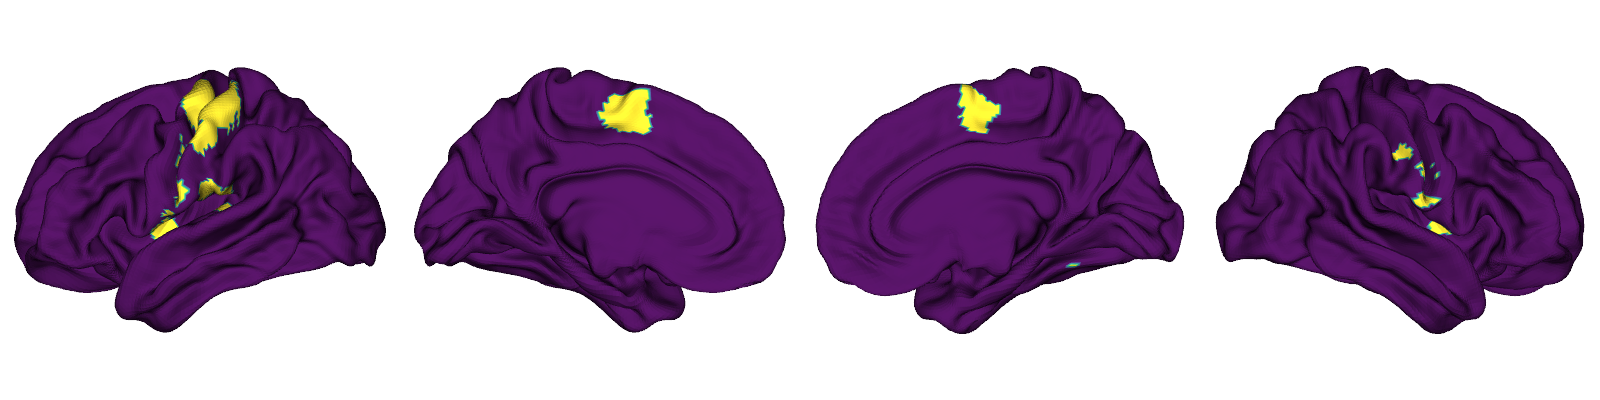

In [19]:
meshes = {
    'L': str(neuromaps.datasets.fetch_fslr()['midthickness'][0]),
    'R': str(neuromaps.datasets.fetch_fslr()['midthickness'][1])
}

plot_surface(macm_fslr, meshes)

In [20]:
ca_colors = list(hcp.ca_network['rgba'].values())
ca_colors[0][3]=1
ca_cmap = LinearSegmentedColormap.from_list('CA', ca_colors, 13)
plt.register_cmap('CA', ca_cmap) # You only have to do this once

In [21]:
ca_ctx = hcp.cortex_data(hcp.ca_network['map_all'])

In [22]:
plot_surface(ca_ctx, meshes, cmap='CA', filename= os.path.join(BASE_DIR, 'Figures/Publication/Figure6/6a_Ji_cerebral_network_parcellation'))

'/data/project/cerebellum_ale/Figures/Publication/Figure6/6a_Ji_cerebral_network_parcellation.png'

In [23]:
ca_labels = list(hcp.ca_network['labels'].values())[1:]

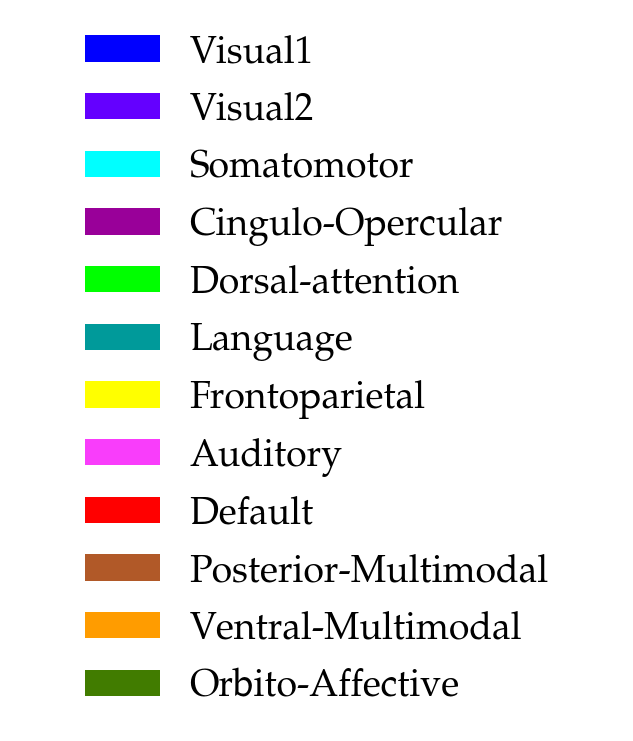

In [24]:
# Create the legend
colors = dict(zip(ca_labels, ca_colors[1:]))

# Create legend handles
legend_handles = [
    mpatches.Patch(facecolor=colors[label], edgecolor="none", label=label) for label in colors
]

# Create a figure for the legend
plt.figure(figsize=(4, 2))

# Add the legend to the figure
plt.legend(handles=legend_handles, fontsize=14, loc="center", frameon=False)

# Remove the axis
plt.axis("off")

# Save the plot
plt.savefig(os.path.join(BASE_DIR, 'Figures/Publication/Figure6/6a_Ji_cerebral_network_parcellation-legend.png'), dpi=300, bbox_inches='tight')

# Show the plot (optional, if you want to visualize the legend before saving)
plt.show()


# Load Tian et al. (2020) subcortical parcellation
## And resample it to the mask of the MACM data

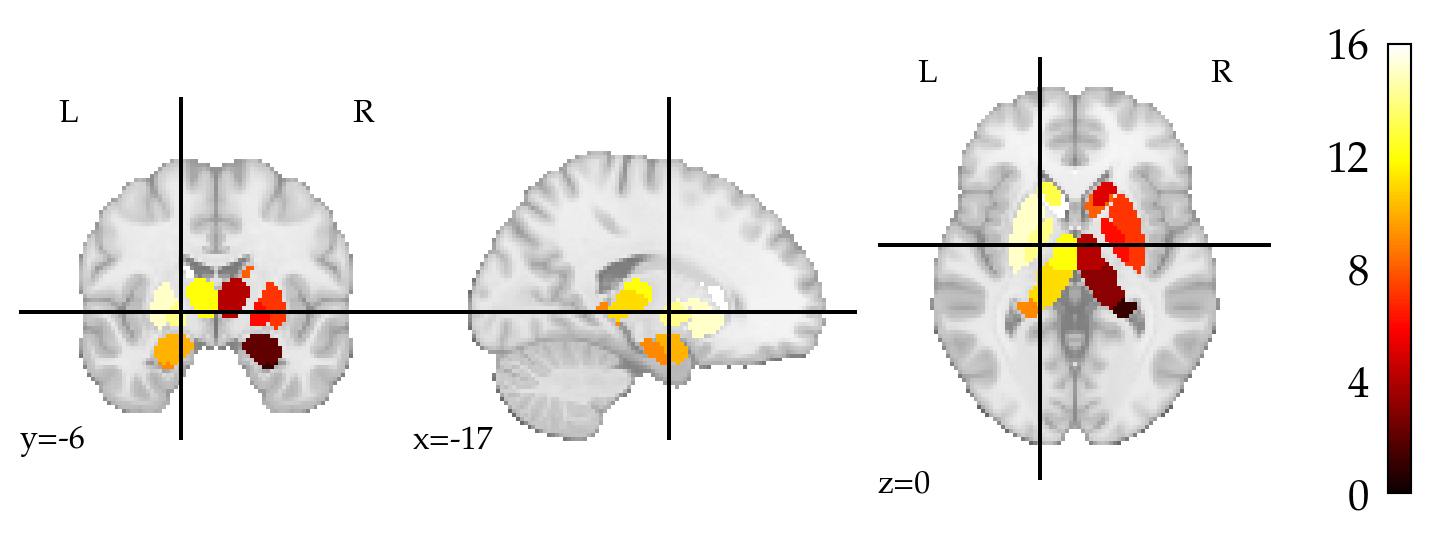

In [25]:
tian = nibabel.load(os.path.join(INPUT_DIR,'maps/Tian_Subcortex_S1_3T.nii'))
mask = nibabel.load(os.path.join(INPUT_DIR, 'maps/Grey10.nii.gz'))
tian_2mm = nilearn.image.resample_to_img(tian, mask)
nilearn.plotting.plot_stat_map(tian_2mm)

In [26]:
counts = pd.DataFrame({
    'macm': macm_bin.get_fdata().flatten(),
    'tian': tian_2mm.get_fdata().flatten() 
}).groupby('macm')['tian'].value_counts(sort=False)[(1, slice(None))]
counts

tian
0.0     7735
3.0       26
4.0       66
6.0        1
7.0       65
11.0     177
12.0     130
14.0       1
15.0     208
Name: count, dtype: int64

# Loop over domains

In [27]:
from tqdm import tqdm
counts = {}

for macm_path in tqdm(sorted(glob.glob(
    '/data/project/cerebellum_ale/output/SALE/*/*/corr_cluster_h-001_k-50_mask-D2009_MNI_z_macm/corr_cluster_k-50_z.nii.gz'
))):
    # todo: use re
    subbd = (macm_path
             .split('/corr_cluster_h-001_k-50_mask-D2009_MNI_z_macm/corr_cluster_k-50_z.nii.gz')[0]
             .split('/data/project/cerebellum_ale/output/SALE/')[1]
             .split('/')[1]
            )
    # binarize
    macm_bin = nilearn.image.binarize_img(macm_path)
    # counts
    counts[subbd] = pd.DataFrame({
        'macm': macm_bin.get_fdata().flatten(),
        'tian': tian_2mm.get_fdata().flatten() 
    }).groupby('macm')['tian'].value_counts(sort=False)[(1, slice(None))]

counts = pd.DataFrame(counts).sort_index()

# Define the list of valid subdomains
valid_MACMs = ['Action', 'Action.Execution', 'Action.Execution.Speech', 'Cognition.Memory.Working', 'Perception.Vision']

# Filter the counts DataFrame to only keep the columns in the valid subdomains list
counts = counts.loc[:, counts.columns.intersection(valid_MACMs)]

# Display the filtered DataFrame
counts

100%|████████████████████████████████████████████████████████████████████| 12/12 [00:04<00:00,  2.83it/s]


Action.Execution.Speech  Action.Execution  Action  \
tian                                                      
0.0                    3792.0              8151    7735   
3.0                       NaN                30      26   
4.0                       NaN                88      66   
6.0                       5.0                 2       1   
7.0                      81.0                61      65   
11.0                     56.0               177     177   
12.0                     65.0               124     130   
14.0                     11.0                 3       1   
15.0                     55.0               213     208   

      Cognition.Memory.Working  Perception.Vision  
tian                                               
0.0                      806.0             1302.0  
3.0                        NaN                NaN  
4.0                        NaN                NaN  
6.0                        NaN                NaN  
7.0                        NaN                NaN  
11.0                       NaN                NaN  
12.0                       NaN                NaN  
14.0                       NaN                NaN  
15.0                       NaN                NaN

9 rows (Tian Parcels + background) x 5 colums (Valid MACM analyses)..
Drop anything non-subcortical (0.0) and calculate percentages.

In [28]:
counts_sctx = counts.drop(index=0.0).fillna(0)

In [29]:
pct = (counts_sctx / counts_sctx.values.sum(axis=0, keepdims=True)) * 100
# drop NaNs (no subcortical voxels in MACM)
pct = pct.dropna(axis=1)

In [30]:
labels = np.loadtxt(os.path.join(INPUT_DIR,
    'maps/Tian_Subcortex_S1_3T_label.txt'),
    dtype=str
)
labels

array(['HIP-rh', 'AMY-rh', 'pTHA-rh', 'aTHA-rh', 'NAc-rh', 'GP-rh',
       'PUT-rh', 'CAU-rh', 'HIP-lh', 'AMY-lh', 'pTHA-lh', 'aTHA-lh',
       'NAc-lh', 'GP-lh', 'PUT-lh', 'CAU-lh'], dtype='<U7')

In [31]:
import itertools
labels_clean = [
    f'{h} {struct}' for h, struct in \
    itertools.product(
        ['R', 'L'],
        ['Hippocampus',
         'Amygdala',
         'Posterior Thalamus',
         'Anterior Thalamus',
         'Nucleus Accumbens',
         'Globus Pallidum',
         'Putamen',
         'Caudate']
    )
]
labels_clean

['R Hippocampus',
 'R Amygdala',
 'R Posterior Thalamus',
 'R Anterior Thalamus',
 'R Nucleus Accumbens',
 'R Globus Pallidum',
 'R Putamen',
 'R Caudate',
 'L Hippocampus',
 'L Amygdala',
 'L Posterior Thalamus',
 'L Anterior Thalamus',
 'L Nucleus Accumbens',
 'L Globus Pallidum',
 'L Putamen',
 'L Caudate']

In [32]:
pct

Action.Execution.Speech  Action.Execution     Action
tian                                                      
3.0                  0.000000          4.297994   3.857567
4.0                  0.000000         12.607450   9.792285
6.0                  1.831502          0.286533   0.148368
7.0                 29.670330          8.739255   9.643917
11.0                20.512821         25.358166  26.261128
12.0                23.809524         17.765043  19.287834
14.0                 4.029304          0.429799   0.148368
15.0                20.146520         30.515759  30.860534

In [33]:
pct_full = (
    pd.concat([
        pct,
        pd.Series(np.arange(1, 17)).rename('index')
    ], axis=1)
    .set_index('index')
    .sort_index()
    .fillna(0)
)

In [34]:
pct_full

Action.Execution.Speech  Action.Execution     Action
index                                                      
1                     0.000000          0.000000   0.000000
2                     0.000000          0.000000   0.000000
3                     0.000000          0.000000   0.000000
4                     0.000000          4.297994   3.857567
5                     0.000000         12.607450   9.792285
6                     0.000000          0.000000   0.000000
7                     1.831502          0.286533   0.148368
8                    29.670330          8.739255   9.643917
9                     0.000000          0.000000   0.000000
10                    0.000000          0.000000   0.000000
11                    0.000000          0.000000   0.000000
12                   20.512821         25.358166  26.261128
13                   23.809524         17.765043  19.287834
14                    0.000000          0.000000   0.000000
15                    4.029304          0.429799   0.148368
16                   20.146520         30.515759  30.860534

Text(167.40104166666669, 0.5, '')

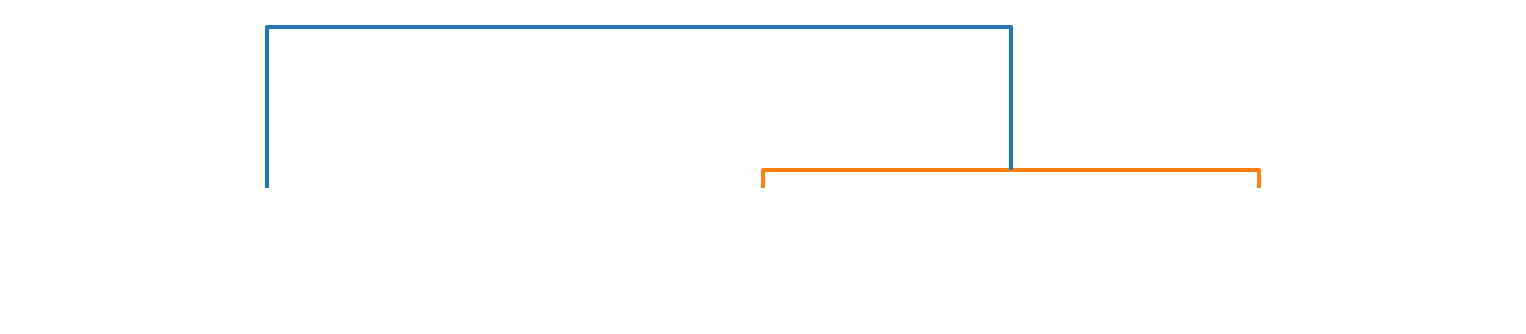

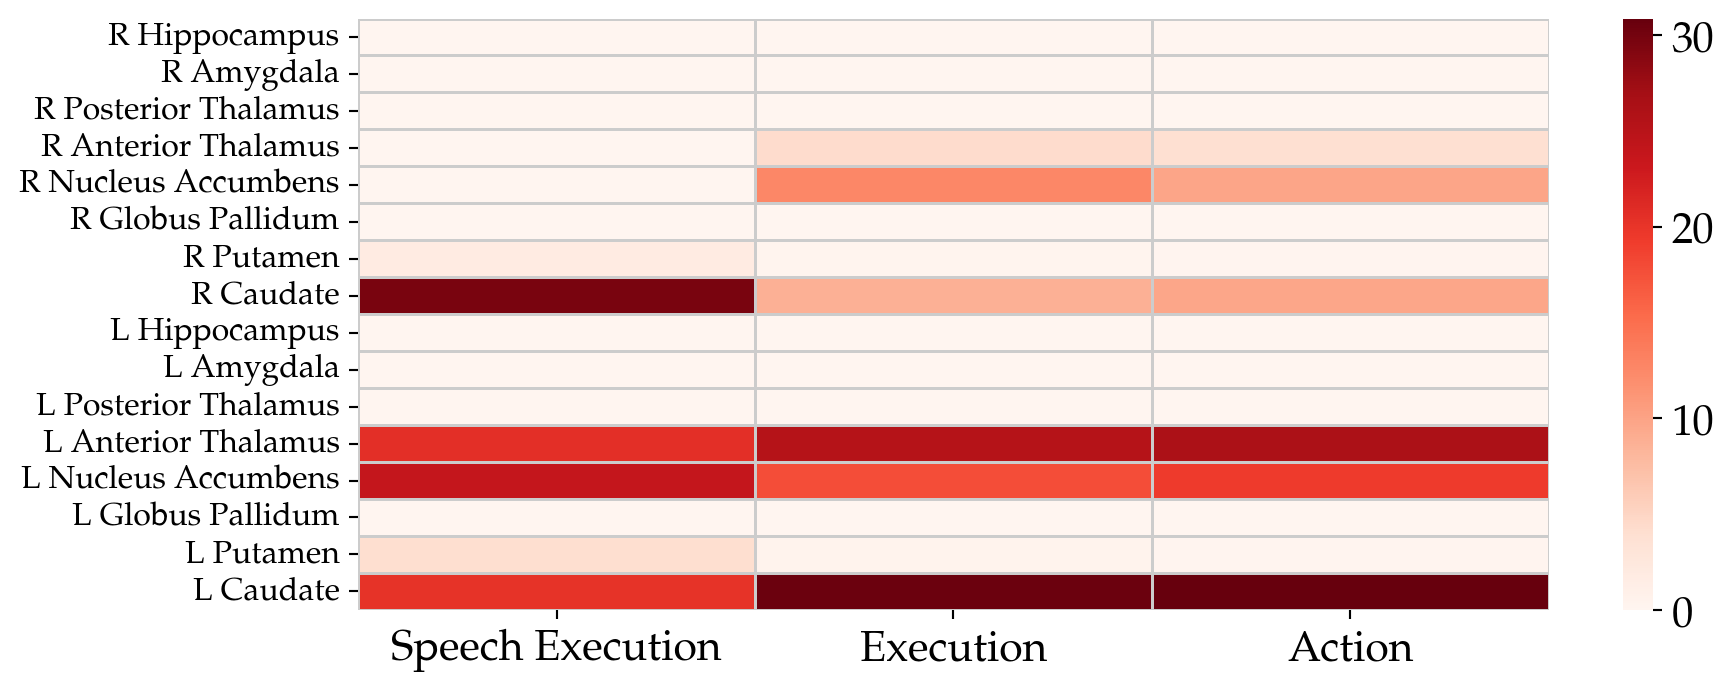

In [35]:
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram

# hierarchical clustering
model = AgglomerativeClustering(n_clusters=None, distance_threshold=0)
model.fit(pct.T)

def create_linkage_matrix(model):
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)

    for i, (left_child, right_child) in enumerate(model.children_):
        count_left = 1 if left_child < n_samples else counts[left_child - n_samples]
        count_right = 1 if right_child < n_samples else counts[right_child - n_samples]
        counts[i] = count_left + count_right

    linkage_matrix = np.column_stack([model.children_, model.distances_, counts]).astype(float)

    return linkage_matrix

# linkage matrix
linkage_matrix = create_linkage_matrix(model)

# plot the dendrogram and extract the leaf order
fig, ax = plt.subplots(figsize=(10, 2))
dendro = dendrogram(linkage_matrix, show_contracted=True, ax=ax, no_labels=True)
# ax.set_title("Hierarchical Clustering Dendrogram")
# ax.set_ylabel("Distance")
ax.set_ylim([-25, ax.get_ylim()[1]])
ax.axis('off')

# Save the dendrogram to file if wanted. We do that in the Script for Figure 7 instead.
# plt.savefig(os.path.join(BASE_DIR, 'Figures/Publication/Figure7/Tian2022_percentage_dendrogram.png'), bbox_inches='tight', dpi=300)


# extract the ordering
leaf_order = dendro['leaves']

# reorder the original data
pct_reordered = pct_full.iloc[:, leaf_order]

# plot the reordered data
fig, ax = plt.subplots(figsize=(10, 4))
sns.heatmap(pct_reordered, cmap='Reds', linewidths=1, linecolor='.8', ax=ax)
ax.set_xticklabels(subdomain_labels.loc[pct_reordered.columns], rotation=0, horizontalalignment='center')
ax.set_yticks(np.arange(len(labels_clean))+0.5)
ax.set_yticklabels(labels_clean, rotation=0, fontsize=12)
ax.set_ylabel('')

# Save the heatmap to file if wanted. We do that in the Script for Figure 7 instead.
# plt.savefig(os.path.join(BASE_DIR, 'Figures/Publication/Figure7/Tian2022_percentage_heatmap.png'), bbox_inches='tight', dpi=300)

# Plotting of the subcortical MACM maps

100%|████████████████████████████████████████████████████████████████████| 12/12 [00:11<00:00,  1.03it/s]


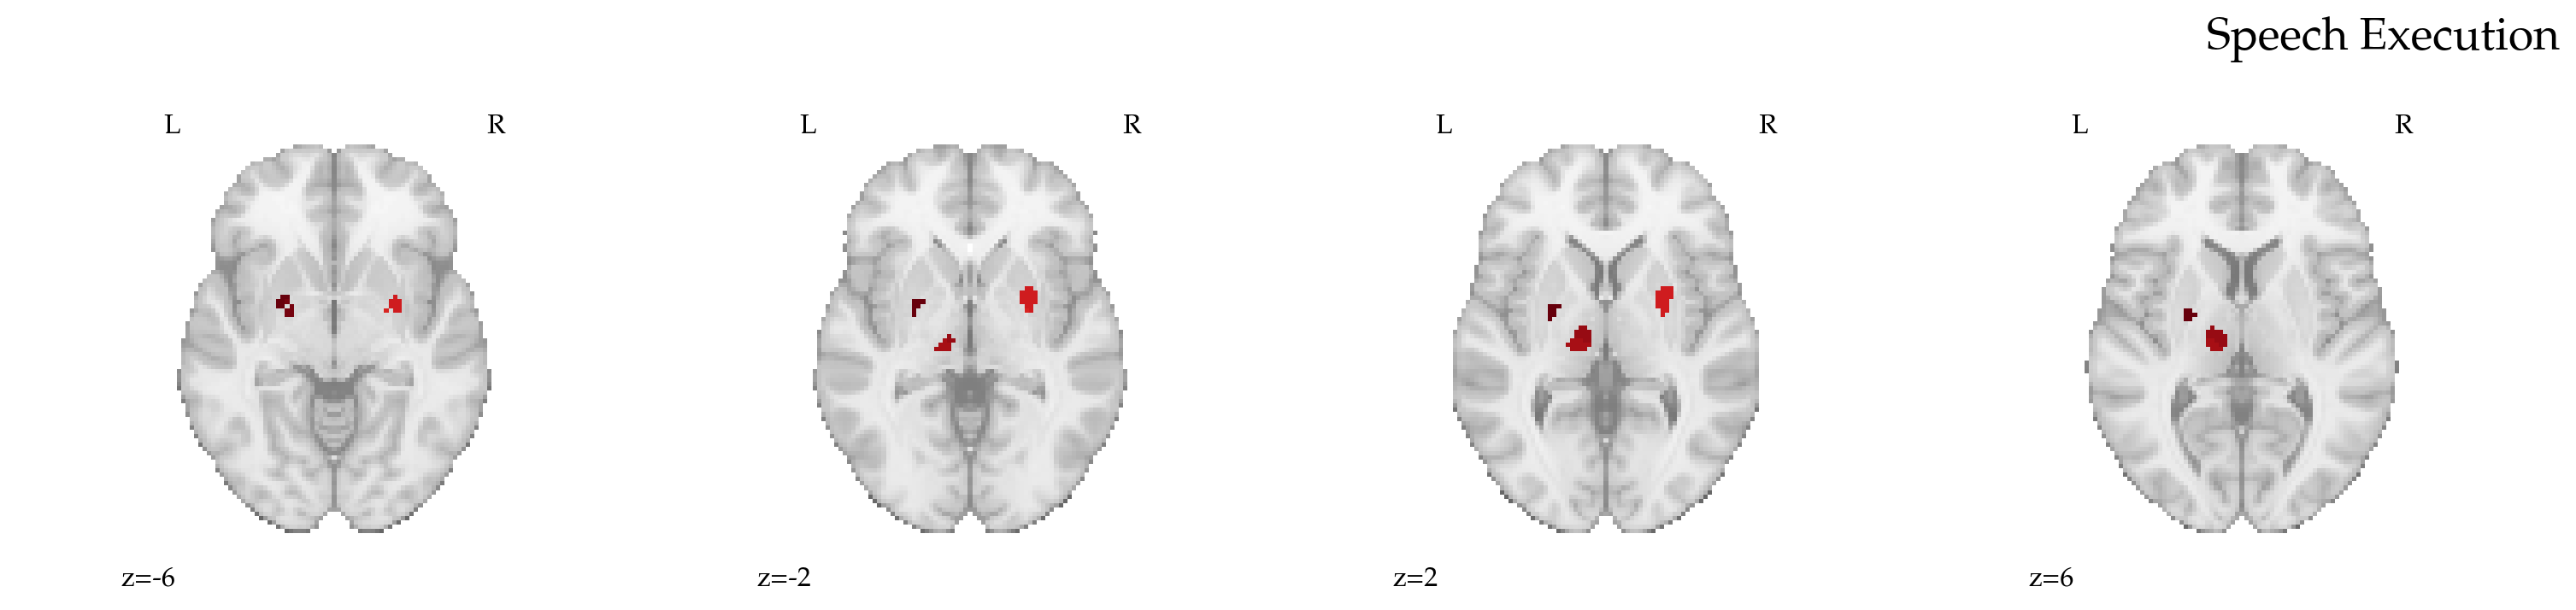

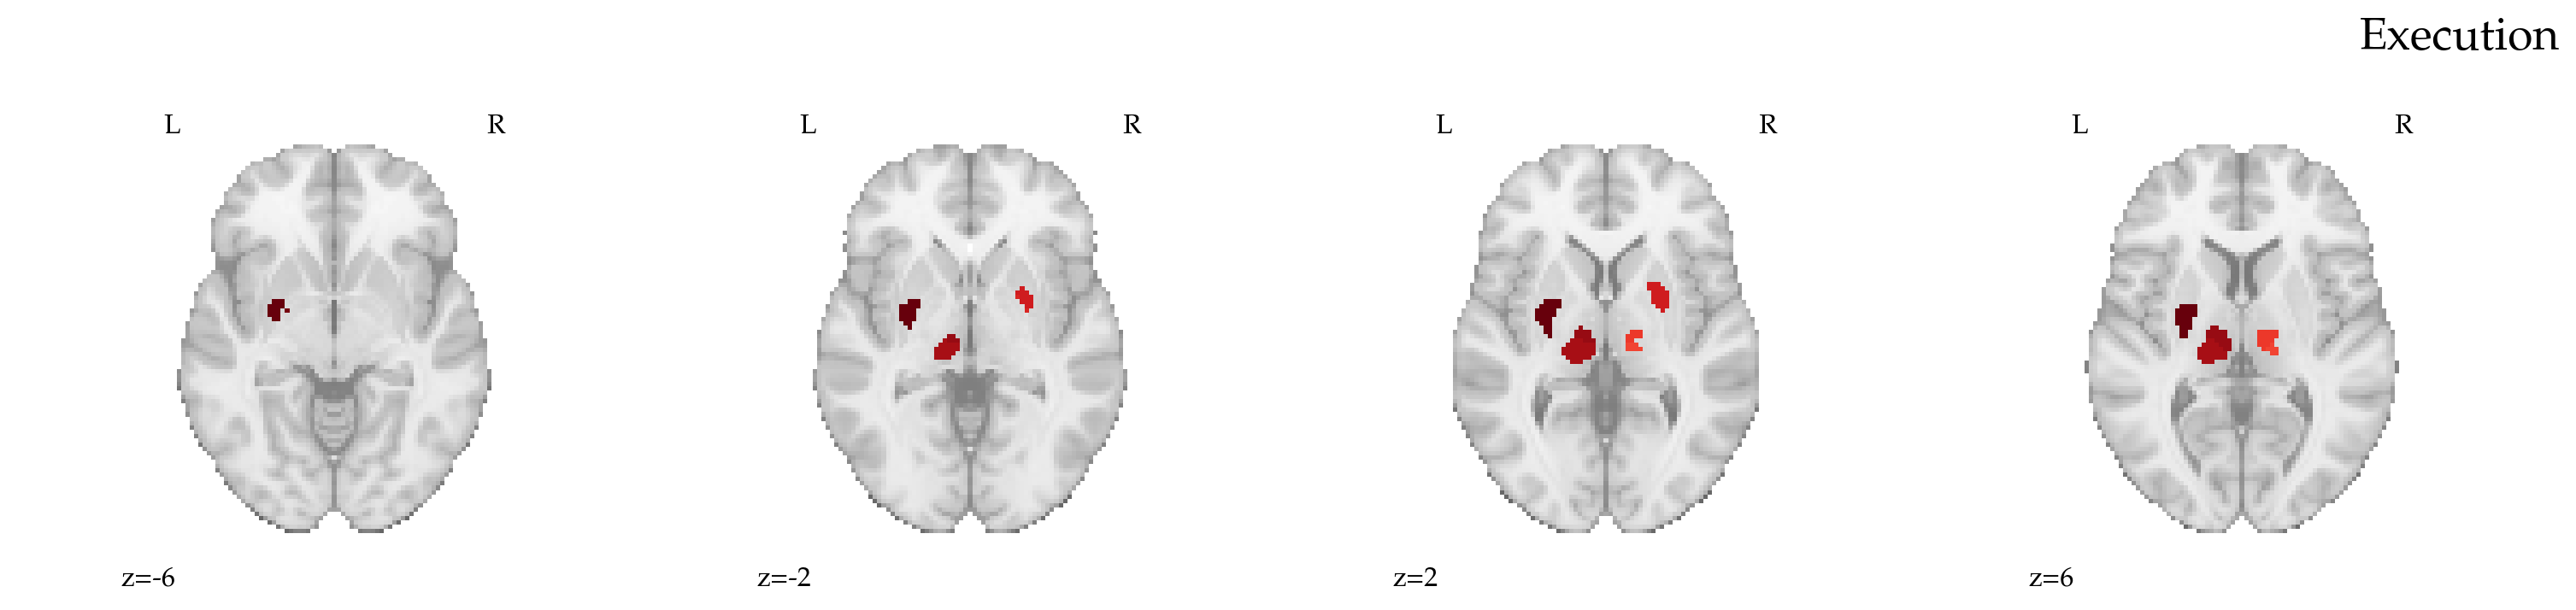

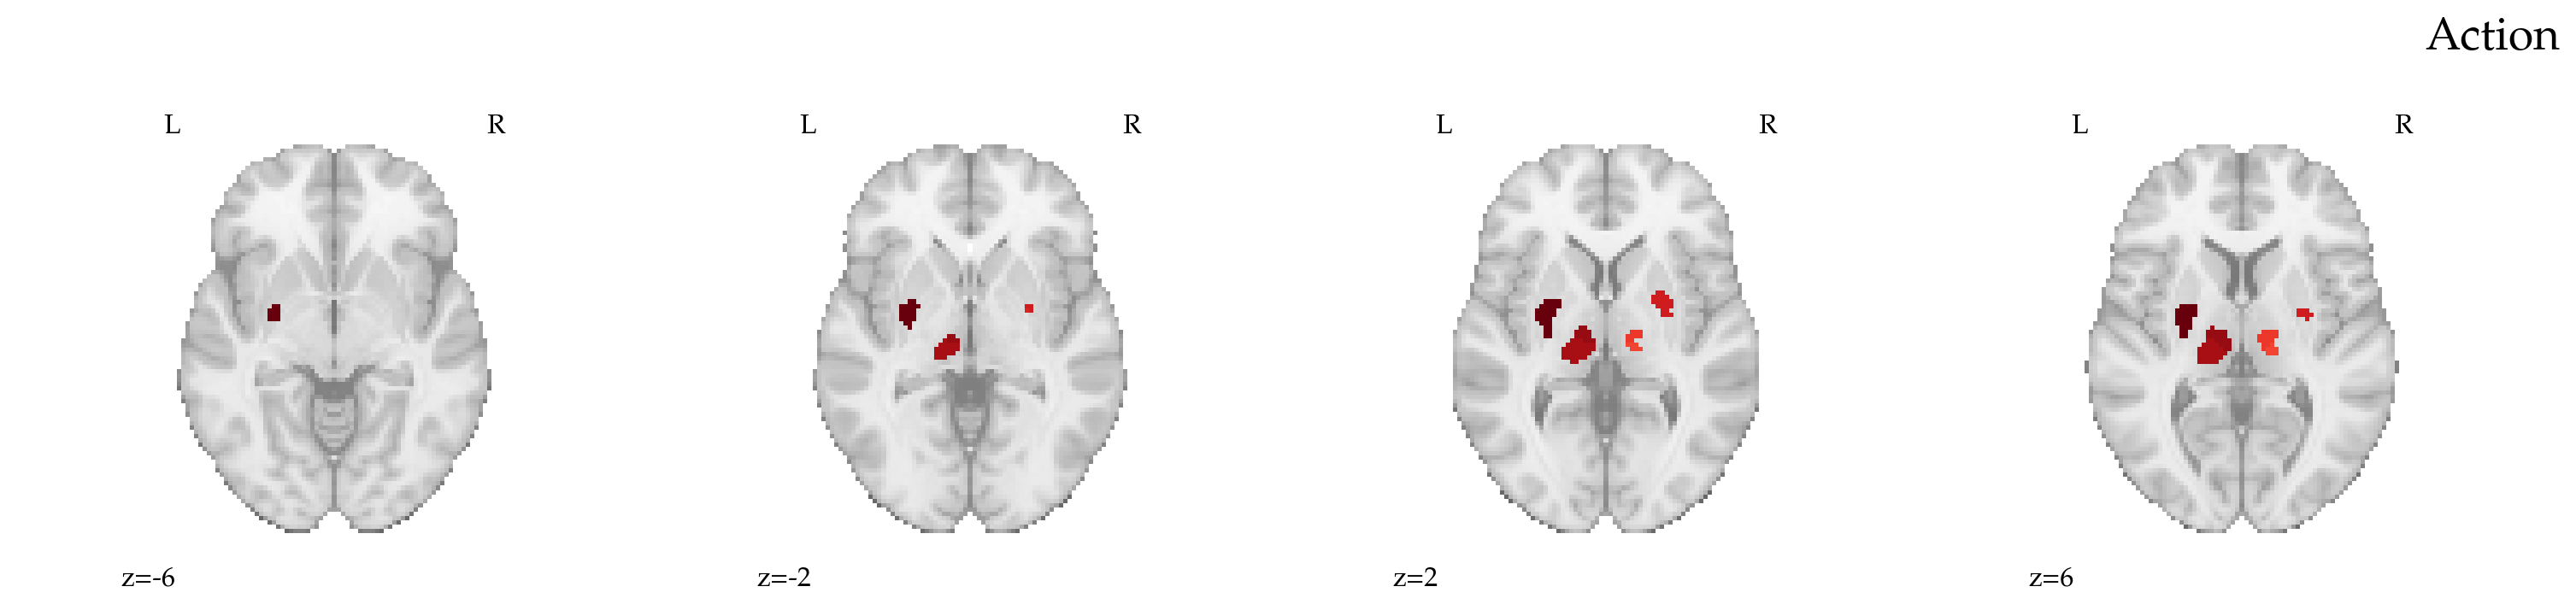

In [36]:
import re
from nilearn.image import resample_to_img

tian = nibabel.load(os.path.join(INPUT_DIR,'maps/Tian_Subcortex_S1_3T.nii'))
mask = nibabel.load(os.path.join(INPUT_DIR, 'maps/Grey10.nii.gz'))
tian_2mm = nilearn.image.resample_to_img(tian, mask) # Resample Tian parcellation.

# Loop over all MACM maps
for macm_path in tqdm(sorted(glob.glob(
    '/data/project/cerebellum_ale/output/SALE/*/*/corr_cluster_h-001_k-50_mask-D2009_MNI_z_macm/corr_cluster_k-50_z.nii.gz'
))):
    # Extract the subdomain name using regular expressions or string manipulation
    subbd = (macm_path
             .split('/corr_cluster_h-001_k-50_mask-D2009_MNI_z_macm/corr_cluster_k-50_z.nii.gz')[0]
             .split('/data/project/cerebellum_ale/output/SALE/')[1]
             .split('/')[1]
            )
    
    # Load the MACM map
    macm_img = nilearn.image.load_img(macm_path)
    
    # Binarize the MACM map
    macm_bin = nilearn.image.binarize_img(macm_img)
    
    # Apply the subcortex mask to the binarized MACM map
    macm_bin_crop = nilearn.image.math_img('img1 * img2', img1=macm_bin, img2=tian_2mm)
    
    # Convert the cropped MACM map to a numpy array and check if there's any data. This should concur with the counts data after excluding extra-subcortical voxels (see above).
    macm_bin_crop_data = macm_bin_crop.get_fdata()
    if np.any(macm_bin_crop_data):  # Only plot if there's any data in the cropped MACM map
        
        # Get the nicer label for the current subdomain
        label = subdomain_labels.get(subbd, subbd)  # Subdomain name will be used when no label mapping exists.
        
        # Create a new figure
        fig, ax = plt.subplots(figsize=(20, 4))
        
        nilearn.plotting.plot_stat_map(
            macm_bin_crop, 
            cmap='Reds', 
            display_mode='z', 
            cut_coords=[-6, -2, 2, 6],  # Adjust the slices as needed. We hide z=-22, z=-16 and z=-10 because they are completely empty. ## -22, -16, -10, 
            title=None,  # Disable the title in plot_stat_map
            axes=ax,
            colorbar=False
        )
        
        # Set the title using Matplotlib to avoid the black box background
        ax.set_title(f"{label}", size=20, backgroundcolor='none', loc = 'right', y = 1.05, fontweight = 'bold')
        
        # Optionally, you can save the plots to a file instead of additonally to displaying them interactively
        plt.savefig(os.path.join(BASE_DIR, f'Figures/Publication/Figure6/Subcortex/{subbd}_macm_thres_tian2020.png'))


## Plot the subcortical parcellation with attractive color scheme

In [37]:
# Path to your labels file
labels_file = os.path.join(INPUT_DIR, 'maps/Tian_Subcortex_S1_3T_label.txt')

# Read the labels
with open(labels_file, 'r') as file:
    labels = [line.strip() for line in file.readlines()]


In [38]:
# Define a list of colors for each category
colors = [
    '#e6194b', '#3cb44b', '#ffe119', '#4363d8',
    '#f58231', '#911eb4', '#46f0f0', '#f032e6',
    '#bcf60c', '#fabebe', '#008080', '#e6beff',
    '#9a6324', '#fffac8', '#800000', '#aaffc3'
]

In [39]:
# Load your nifti image
tian_data = tian_2mm.get_fdata()

# Prevent potential compatibility issues with int64
labeled_data = np.zeros(tian_data.shape, dtype=np.int32)

for i, label in enumerate(labels, start=1):
    # Assign a unique integer to each label
    labeled_data[tian_data == i] = i

# Add the labels to the nifti images
labeled_img = nibabel.Nifti1Image(labeled_data, tian_2mm.affine)


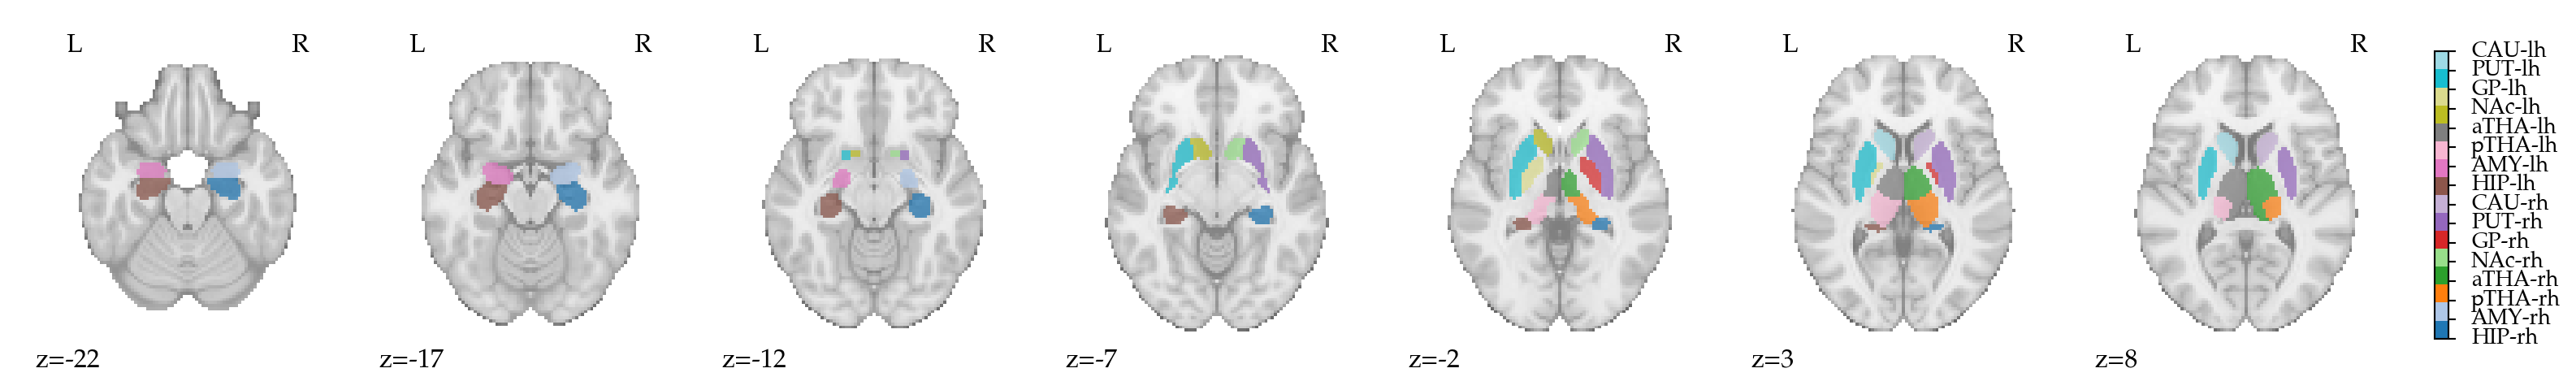

In [40]:
# Colormap
cmap = plt.cm.get_cmap('tab20', len(labels)) # Using 'tab20' as the colormap. Not sure what Tian et al. used and this looks nice.

# Plotting (the labeled image from the previous)
display = plot_roi(
    labeled_img,
    display_mode='z', 
    colorbar=False,  # Disable default colorbar
    cut_coords=[-22, -17, -12, -7, -2, 3, 8],
    cmap=cmap  
)

# Colorbar from matplotlib itself
fig = display.frame_axes.figure
cax = fig.add_axes([1.0, 0.1, 0.02, 0.8]) # Set the position of the colorbar

# Create the colorbar
norm = plt.Normalize(vmin=1, vmax=len(labels))
cbar = fig.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap), cax=cax)

# Add colorbar ticks and labels
cbar.set_ticks(np.arange(1, len(labels) + 1))
cbar.set_ticklabels(labels) # label Look-up table: https://github.com/yetianmed/subcortex/blob/master/Group-Parcellation/3T/Subcortex-Only/Nomenclature-subcortex-parcellation-hierarchy-3T.pdf

# Font size and position of labels
for label in cbar.ax.get_yticklabels():
    label.set_fontsize(10)
    label.set_verticalalignment('center')  # Align labels centrally.

# Adjust the spacing
cbar.ax.tick_params(pad=7)  # Distance between ticks and labels.

# Stretch out the colorbar
cax.set_aspect(1.4)  # Aspect ratio for the colorbar. Some stretch was needed.

# Save the plot
fig.savefig(os.path.join(BASE_DIR, 'Figures/Publication/Figure6/6a_Tian_connectivity-gradient_parcellation+legend.png'), dpi=300, bbox_inches='tight')

# Show the plot
plt.show()

# Plot the cerebellum

In [41]:
## Import data into dictionaries
zmaps = {}
surf_zmaps = {}
zmaps_thr = {}
zmaps_thr_bin = {}
surf_zmaps_thr = {}
surf_zmaps_thr_bin = {}

domains = ['Action', 'Cognition', 'Emotion', 'Interoception', 'Perception']
MASK_NAME = 'D2009_MNI'
mask_img = os.path.join(INPUT_DIR, f'maps/{MASK_NAME}.nii.gz')
k = 50

for domain in domains:
    domain_path = os.path.join(OUTPUT_DIR, 'SALE', f'{domain}')
    subdomains = os.listdir(domain_path)
    for subdomain in subdomains:
        subdomain_path = os.path.join(domain_path, subdomain)
        if (not os.path.isdir(subdomain_path)):
            continue
        print(subdomain)
        
        # load uncorrected results
        z_orig = nibabel.load(os.path.join(subdomain_path, 'uncorr_z.nii.gz'))
        # mask to the proper mask
        z_masked = nilearn.image.math_img("m * img", img=z_orig, m=mask_img)
        # record 3d and flattened unthresholded images
        zmaps[subdomain] = z_masked
        surf_zmaps[subdomain] = SUITPy.flatmap.vol_to_surf(zmaps[subdomain], space = 'SPM').squeeze()
        
        # do cluster extent thresholding if needed
        corr_cluster_z_path = os.path.join(subdomain_path, f'corr_cluster_h-001_k-{k}_mask-{MASK_NAME}_z.nii.gz')
        #if not os.path.exists(corr_cluster_z_path):
         #   logp_orig = nibabel.load(os.path.join(subdomain_path, 'uncorr_logp.nii.gz'))
          #  logp_masked = nilearn.image.math_img("m * img", img=logp_orig, m=mask_img)
            # cluster extent correction
           # cres = cluster_extent_correction({'z': z_masked, 'logp': logp_masked}, k=50, height_thr=0.01)
            # save corrected results
            #for map_name, img in cres.items():
             #   img.to_filename(os.path.join(subdomain_path, f'corr_cluster_h-001_k-{k}_mask-{MASK_NAME}_{map_name}.nii.gz'))
        # record 3d and flattened thresholded images
        zmaps_thr[subdomain] = nibabel.load(corr_cluster_z_path)
        zmaps_thr_bin[subdomain] = nilearn.image.binarize_img(zmaps_thr[subdomain]) # BINARIZE!
        surf_zmaps_thr[subdomain] = SUITPy.flatmap.vol_to_surf(zmaps_thr[subdomain], space = 'SPM').squeeze()
        surf_zmaps_thr_bin[subdomain] = SUITPy.flatmap.vol_to_surf(zmaps_thr_bin[subdomain], space= 'SPM').squeeze() ## This step is essential for displaying the extent of the (volumetric) clusters correctly onto the flatmap.
# Add stats = 'mode' for the more conservative borders (this maps only cerebeller flatmap voxels where there is a significant cluster at 3 or more of the 6 GM depths).

Action
Action.Imagination
Action.Execution
Action.Observation
Action.Inhibition
Action.Execution.Speech
Cognition.Language
Cognition.Memory
Cognition.Attention
Cognition.Language.Speech
Cognition.Language.Semantics
Cognition.Language.Phonology
Cognition.SocialCognition
Cognition.Reasoning
Cognition
Cognition.Spatial
Cognition.Language.Orthography
Cognition.Memory.Explicit
Cognition.Music
Cognition.Memory.Working
Emotion.Positive.Happiness
Emotion.Negative.Sadness
Emotion.Negative.Fear
Emotion.Positive
Emotion.Negative.Disgust
Emotion.Positive.RewardGain
Emotion.Negative.Anger
Emotion
Emotion.Negative
Interoception
Interoception.Sexuality
Perception.Somesthesis.Pain
Perception
Perception.Olfaction
Perception.Vision
Perception.Audition
Perception.Vision.Motion
Perception.Somesthesis
Perception.Vision.Color
Perception.Vision.Shape


# Loop drawing of borders over all domains

In [43]:
def get_flatmap_mask_boundaries(domain, surf_zmaps_thr_bin): ## Make sure to use the binarized maps for both SALE and SCALE thresholded outputs.
    mask = (surf_zmaps_thr_bin[domain] > 0).astype(int)
    outline = np.zeros_like(mask, dtype=int)
    mesh = nilearn.surface.load_surf_mesh('/data/project/cerebellum_ale/input/maps/FLAT.surf.gii')
    boundary_faces = (mask[mesh.faces].sum(axis=1) == 1)
    mask_boundary_verts = list(
        set(mesh.faces[boundary_faces].flatten()) & \
        set(np.where(mask)[0])
    )
    outline[mask_boundary_verts] = 1
    return outline

In [44]:
# Specifiy the domains
domains = ['Action', 'Cognition', 'Emotion', 'Interoception', 'Perception']

# Dictionary to store boundaries for each domain
boundaries_dict = {}

# Iterate over domains and compute boundaries
for domain in domains:
    boundaries_dict[domain] = get_flatmap_mask_boundaries(domain, surf_zmaps_thr_bin)

# This should now have put boundaries for every domain in boundaries_dict
# Check that keys exist for all domains.

In [45]:
# Load the surface mesh
surface_mesh_file = os.path.join(INPUT_DIR, 'maps/FLAT.surf.gii')
mesh = nilearn.surface.load_surf_mesh(surface_mesh_file)

# Initialize dictionaries to store cluster borders, outline, and boundary faces for each domain
cluster_borders_dict = {}
outline_dict = {}
boundary_faces_dict = {}

# Loop over domains
for domain in ['Action', 'Cognition', 'Emotion', 'Interoception', 'Perception']:
    # Get the binary mask for the current domain
    mask = (surf_zmaps_thr_bin[domain] > 0).astype(int)

    # Get the coordinates of the boundary vertices for the current domain
    outline_dict[domain] = np.zeros_like(mask, dtype=int)
    boundary_faces = (mask[mesh.faces].sum(axis=1) == 1)
    mask_boundary_verts = list(
        set(mesh.faces[boundary_faces].flatten()) & set(np.where(mask)[0])
    )
    cluster_borders_dict[domain] = mesh.coordinates[mask_boundary_verts]

    # Smoothing iterations
    iterations = 2
    for i in range(iterations):
        distmat = scipy.spatial.distance_matrix(cluster_borders_dict[domain], cluster_borders_dict[domain])
        distmat[distmat == 0] = np.NaN
        neighbors = np.where(distmat < 5)
        new_points = (cluster_borders_dict[domain][neighbors[0]] + cluster_borders_dict[domain][neighbors[1]]) / 2
        cluster_borders_dict[domain] = np.concatenate([cluster_borders_dict[domain], new_points], axis=0)

# Plot the cerebellum MACM results + borders of the seeds

In [46]:
# Define the base directory for saving figures
base_figure_dir = os.path.join(BASE_DIR, 'Figures/Publication/Figure6/Cerebellum')

for domain in domains:
    # Construct file path for the current domain
    macm_nifti = os.path.join(OUTPUT_DIR, f'SALE/{domain}/{domain}/corr_cluster_h-001_k-50_mask-D2009_MNI_z_macm/corr_cluster_k-50_z.nii.gz')

    # Check if the file path exists
    if os.path.exists(macm_nifti):
        macm_bin = nilearn.image.binarize_img(macm_nifti) # Binarization
        # Create a new figure and plot the surface data
       
        # Get the current axis of the plot
        ax = plt.gca()

        # Create a new figure and plot the surface data
        surface_map = SUITPy.flatmap.vol_to_surf(macm_bin, space = 'SPM').squeeze(), # Stats = 'SPM' and space = currently 'nanmean', but can be set to 'mode' if a more conservative plot is desired.
        # see https://suitpy.readthedocs.io/en/latest/reference.html,  Diedrichsen et al. (2015) https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0133402
        # and https://github.com/DiedrichsenLab/SUITPy/blob/79ba5656fa284d226357108b95d81c996275e10e/SUITPy/flatmap.py#L33 for details. 

        surface_data = surface_map[0]  # Get the surface map data
        binarized_surface_data = np.where(surface_data > 0, 1, 0) # We need to binarize again, since stats = 'nanmean' (default) averages across 6 GM depths and thus efectively removes binarization in our maps.
            
        # Plot the flatmap for the current subdomain
        SUITPy.flatmap.plot(binarized_surface_data, colorbar=False, cmap=custom_cmap, underscale = [-0.3, 1],  new_figure=False)
 
        # Overlay the cluster borders on top
        ax.plot(cluster_borders_dict[domain][:, 0], cluster_borders_dict[domain][:, 1], # Enable borders if desired.
               color='black', marker='.', linestyle=None, markersize=0.01, linewidth=0)
        
        # Set the title for the plot
        ax.set_title(domain, fontsize=24)
        
        # Define the directory path for saving the figure
        save_dir_domain = os.path.join(base_figure_dir, domain)
        os.makedirs(save_dir_domain, exist_ok=True)  # Create the directory if it does not exist.
        
        # Define the file name for saving the figure
        save_filename = f"{domain}_MACM_Cerebellum-Surface_p001_K50_wborders.png"
        
        # Define the full path to save the figure
        save_path = os.path.join(save_dir_domain, save_filename)
        
        # Save the figure to the specified path
        plt.savefig(save_path, bbox_inches='tight', dpi=300)
        
        # Display the plot (optional)
        # display(plt.gcf())
        
        # Close the plot to release memory (optional)
        plt.close()
        
    else:
        print(f"File path does not exist for domain: {domain}. Skipping...")

File path does not exist for domain: Cognition. Skipping...
File path does not exist for domain: Emotion. Skipping...
File path does not exist for domain: Interoception. Skipping...
File path does not exist for domain: Perception. Skipping...


# MACM results without borders

In [47]:
# Define the base directory for saving figures
base_figure_dir = os.path.join(BASE_DIR, 'Figures/Publication/Figure6/Cerebellum')

for domain in domains:
    # Construct file path for the current domain
    macm_nifti = os.path.join(OUTPUT_DIR, f'SALE/{domain}/{domain}/corr_cluster_h-001_k-50_mask-D2009_MNI_z_macm/corr_cluster_k-50_z.nii.gz')

    # Check if the file path exists
    if os.path.exists(macm_nifti):
        macm_bin = nilearn.image.binarize_img(macm_nifti) # Binarization
        # Create a new figure and plot the surface data
       
        # Get the current axis of the plot
        ax = plt.gca()

        # Create a new figure and plot the surface data
        surface_map = SUITPy.flatmap.vol_to_surf(macm_bin, space = 'SPM').squeeze(), # Stats = 'SPM' and space = currently 'nanmean', but can be set to 'mode' if a more conservative plot is desired.
        # see https://suitpy.readthedocs.io/en/latest/reference.html,  Diedrichsen et al. (2015) https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0133402
        # and https://github.com/DiedrichsenLab/SUITPy/blob/79ba5656fa284d226357108b95d81c996275e10e/SUITPy/flatmap.py#L33 for details. 

        surface_data = surface_map[0]  # Get the surface map data
        binarized_surface_data = np.where(surface_data > 0, 1, 0) # We need to binarize again, since stats = 'nanmean' (default) averages across 6 GM depths and thus efectively removes binarization in our maps.
            
        # Plot the flatmap for the current subdomain
        SUITPy.flatmap.plot(binarized_surface_data, colorbar=False, cmap=custom_cmap, underscale = [-0.3, 1],  new_figure=False)
        
        # Set the title for the plot
        ax.set_title(domain, fontsize=24)
        
        # Define the directory path for saving the figure
        save_dir_domain = os.path.join(base_figure_dir, domain)
        os.makedirs(save_dir_domain, exist_ok=True)  # Create the directory if it does not exist.
        
        # Define the file name for saving the figure
        save_filename = f"{domain}_MACM_Cerebellum-Surface_p001_K50_woborders.png"
        
        # Define the full path to save the figure
        save_path = os.path.join(save_dir_domain, save_filename)
        
        # Save the figure to the specified path
        plt.savefig(save_path, bbox_inches='tight', dpi=300)
        
        # Display the plot (optional)
        # display(plt.gcf())
        
        # Close the plot to release memory (optional)
        plt.close()
        
    else:
        print(f"File path does not exist for domain: {domain}. Skipping...")

File path does not exist for domain: Cognition. Skipping...
File path does not exist for domain: Emotion. Skipping...
File path does not exist for domain: Interoception. Skipping...
File path does not exist for domain: Perception. Skipping...


# MACM seeds
## Color them blue for visual distinction

In [49]:
# Define the base directory for saving figures
base_figure_dir = os.path.join(BASE_DIR, 'Figures/Publication/Figure6/Cerebellum')

for domain in domains:
    # Construct file path for the current domain
    macm_nifti = os.path.join(OUTPUT_DIR, f'SALE/{domain}/{domain}/corr_cluster_h-001_k-50_mask-D2009_MNI_z.nii.gz')

    # Check if the file path exists
    if os.path.exists(macm_nifti):
        macm_bin = nilearn.image.binarize_img(macm_nifti) # Binarization
        # Create a new figure and plot the surface data
       
        # Get the current axis of the plot
        ax = plt.gca()

        # Create a new figure and plot the surface data
        surface_map = SUITPy.flatmap.vol_to_surf(macm_bin, space = 'SPM').squeeze(), # Stats = 'SPM' and space = currently 'nanmean', but can be set to 'mode' if a more conservative plot is desired.
        # see https://suitpy.readthedocs.io/en/latest/reference.html,  Diedrichsen et al. (2015) https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0133402
        # and https://github.com/DiedrichsenLab/SUITPy/blob/79ba5656fa284d226357108b95d81c996275e10e/SUITPy/flatmap.py#L33 for details. 

        surface_data = surface_map[0]  # Get the surface map data
        binarized_surface_data = np.where(surface_data > 0, 1, 0) # We need to binarize again, since stats = 'nanmean' (default) averages across 6 GM depths and thus efectively removes binarization in our maps.
            
        # Plot the flatmap for the current subdomain
        SUITPy.flatmap.plot(binarized_surface_data, colorbar=False, cmap='Paired', underscale = [-0.3, 1],  new_figure=False)
        
        # Set the title for the plot
        ax.set_title(domain, fontsize=24)
        
        # Define the directory path for saving the figure
        save_dir_domain = os.path.join(base_figure_dir, domain)
        os.makedirs(save_dir_domain, exist_ok=True)  # Create the directory if it does not exist.
        
        # Define the file name for saving the figure
        save_filename = f"{domain}_MACM_Cerebellum-Surface_p001_K50_seeds.png"
        
        # Define the full path to save the figure
        save_path = os.path.join(save_dir_domain, save_filename)
        
        # Save the figure to the specified path
        plt.savefig(save_path, bbox_inches='tight', dpi=300)
        
        # Display the plot (optional)
        # display(plt.gcf())
        
        # Close the plot to release memory (optional)
        plt.close()
        
    else:
        print(f"File path does not exist for domain: {domain}. Skipping...")

# Subdomains

In [50]:
zmaps = {}
zmaps_thr = {}
zmaps_thr_strict = {}
zmaps_thr_strict_bin = {}

surf_zmaps = {}
surf_zmaps_thr = {}
surf_zmaps_thr_strict = {}
surf_zmaps_thr_strict_bin = {}

domains = ['Action', 'Cognition', 'Emotion', 'Interoception', 'Perception']
MASK_NAME = 'D2009_MNI'
mask_img = os.path.join(INPUT_DIR, f'maps/{MASK_NAME}.nii.gz')
k = 50

# Make a list of valid subdomains (N > 15 experiments within the seed (SALE result in the cerebellum).
valid_MACMs = ['Action', 'Execution', 'Execution.Speech', 'Memory.Working', 'Vision']

for domain in domains:
    domain_path = os.path.join(OUTPUT_DIR, 'SALE', f'{domain}')
    
    # Exclude subdomains with the same name as the domains
    subdomains = [subdomain for subdomain in valid_MACMs if subdomain not in domains] # Do not add domains
    
    for subdomain in subdomains:
        # Construct the combined key for accessing the surf_zmaps_thr_strict_bin dictionary
        combined_key = f"{domain}.{subdomain}"
        subdomain_path = os.path.join(domain_path, combined_key)
        if (not os.path.isdir(subdomain_path)):
            continue
        
        # load uncorrected results
        z_orig = nibabel.load(os.path.join(subdomain_path, 'uncorr_z.nii.gz'))
        # mask to the proper mask
        z_masked = nilearn.image.math_img("m * img", img=z_orig, m=mask_img)
        # record 3d and flattened unthresholded images
        zmaps[combined_key] = z_masked
        surf_zmaps[combined_key] = SUITPy.flatmap.vol_to_surf(zmaps[combined_key], space = 'SPM').squeeze()
        
        # do cluster extent thresholding if needed
        corr_cluster_z_path_strict = os.path.join(subdomain_path, f'corr_cluster_h-001_k-{k}_mask-{MASK_NAME}_z.nii.gz')
        
        #if not os.path.exists(corr_cluster_z_path):
         #   logp_orig = nibabel.load(os.path.join(subdomain_path, 'uncorr_logp.nii.gz'))
          #  logp_masked = nilearn.image.math_img("m * img", img=logp_orig, m=mask_img)
            # cluster extent correction
           # cres = cluster_extent_correction({'z': z_masked, 'logp': logp_masked}, k=50, height_thr=0.01)
            # save corrected results
            #for map_name, img in cres.items():
             #   img.to_filename(os.path.join(subdomain_path, f'corr_cluster_h-01_k-{k}_mask-{MASK_NAME}_{map_name}.nii.gz'))
       
        # record 3d and flattened thresholded (p < .001 and K=50) images
        zmaps_thr_strict[combined_key] = nibabel.load(corr_cluster_z_path_strict)
        zmaps_thr_strict_bin[combined_key] = nilearn.image.binarize_img(zmaps_thr_strict[combined_key]) # BINARIZE!
        surf_zmaps_thr_strict[combined_key] = SUITPy.flatmap.vol_to_surf(zmaps_thr_strict[combined_key], space='SPM').squeeze()
        surf_zmaps_thr_strict_bin[combined_key] = SUITPy.flatmap.vol_to_surf(zmaps_thr_strict_bin[combined_key],  space= 'SPM').squeeze() ## This step is essential for how the extent of the (volumetric) clusters is displayed onto the flatmap.
        
        print(combined_key)
 # stats = 'mode' for the more conservative version

Action.Execution
Action.Execution.Speech
Cognition.Memory.Working
Perception.Vision


In [51]:
# Add the number of experiments per domain.
domain_exps_macm = {'Action': 197,
}

In [52]:
subdomains_exps_macm = {'Action.Execution': 251,
                   'Action.Execution.Speech': 80, 
                   'Cognition.Memory.Working': 21,
                   'Perception.Vision': 34}

In [53]:
both_exps_macm = {'Action': 197,
                  'Action.Execution': 251,
                  'Action.Execution.Speech': 80, 
                  'Cognition.Memory.Working': 21,
                  'Perception.Vision': 34}

In [54]:
subdomain_labels = {'Action.Execution': 'Execution',
                   'Action.Execution.Speech': 'Speech Execution', 
                   'Cognition.Memory.Working': 'Working Memory',
                   'Perception.Vision': 'Vision'}

In [55]:
subdomain_order = pd.Series(subdomains_exps_macm).sort_values().index # This should only include valid (N > 15 MACM analyses)
subdomain_order

Index(['Cognition.Memory.Working', 'Perception.Vision',
       'Action.Execution.Speech', 'Action.Execution'],
      dtype='object')

# Create the border mapping

In [56]:
def get_flatmap_mask_boundaries(subdomain, surf_zmaps_thr_strict_bin): # Binarize!
    mask = (surf_zmaps_thr_strict_bin[subdomain] > 0).astype(int)
    outline = np.zeros_like(mask, dtype=int)
    mesh = nilearn.surface.load_surf_mesh('/data/project/cerebellum_ale/input/maps/FLAT.surf.gii')
    boundary_faces = (mask[mesh.faces].sum(axis=1) == 1)
    mask_boundary_verts = list(
        set(mesh.faces[boundary_faces].flatten()) & set(np.where(mask)[0])
    )
    outline[mask_boundary_verts] = 1
    return outline


In [57]:
# Initialize dictionary to store boundaries
boundaries_dict_strict = {}

# Iterate over domains
for domain in domains:
    domain_path = os.path.join(OUTPUT_DIR, 'SALE', f'{domain}')
    
    # Exclude subdomains with the same name as the domains
    subdomains = [subdomain for subdomain in valid_MACMs if subdomain not in domains] # Do not add domains
    
    for subdomain in subdomains:
        # Construct the combined key for accessing the surf_zmaps_thr_strict_bin dictionary
        combined_key = f"{domain}.{subdomain}"
        subdomain_path = os.path.join(domain_path, combined_key)
        if not os.path.isdir(subdomain_path):
            continue

        # Ensure that the dictionary entry for the domain exists
        if subdomain not in boundaries_dict_strict:
            boundaries_dict_strict[combined_key] = {}

        # Compute boundaries for the current subdomain and store in the dictionary
        boundaries_dict_strict[combined_key] = get_flatmap_mask_boundaries(combined_key, surf_zmaps_thr_strict_bin) ## Use the Binarized maps

# Now boundaries_dict should contain boundaries for every subdomain in each domain
# You can access them like boundaries_dict[subdomain][domain]
# Check that keys exist for all domains and subdomains.

In [58]:
# Load the surface mesh
surface_mesh_file = os.path.join(INPUT_DIR, 'maps/FLAT.surf.gii')
mesh = nilearn.surface.load_surf_mesh(surface_mesh_file)

# Initialize dictionaries to store cluster borders, outline, and boundary faces for each domain
cluster_borders_dict_strict = {}
outline_dict_strict = {}
boundary_faces_dict_strict = {}

for domain in domains:
    domain_path = os.path.join(OUTPUT_DIR, 'SALE', domain)
    
    # Exclude subdomains with the same name as the domains
    subdomains = [subdomain for subdomain in valid_MACMs if subdomain not in domains]  # Do not add domains
    
    for subdomain in subdomains:
        
        # Construct the combined key for accessing the surf_zmaps_thr_strict_bin dictionary
        combined_key = f"{domain}.{subdomain}"
        subdomain_path = os.path.join(domain_path, combined_key)
        if not os.path.isdir(subdomain_path):
            continue

        # Ensure that the dictionary entry for the subdomain exists
        if combined_key not in cluster_borders_dict_strict:
            cluster_borders_dict_strict[combined_key] = {}
            outline_dict_strict[combined_key] = {}
            boundary_faces_dict_strict[combined_key] = {}

        # Get the binary mask for the current subdomain
        if combined_key not in surf_zmaps_thr_strict_bin:
            print(f"Skipping {combined_key} as it is not in surf_zmaps_thr_strict_bin")
            continue

        mask = (surf_zmaps_thr_strict_bin[combined_key] > 0).astype(int)

        # Get the coordinates of the boundary vertices for the current subdomain
        outline_dict_strict[combined_key] = np.zeros_like(mask, dtype=int)
        boundary_faces = (mask[mesh.faces].sum(axis=1) == 1)
        mask_boundary_verts = list(
            set(mesh.faces[boundary_faces].flatten()) & set(np.where(mask)[0])
        )
        cluster_borders_dict_strict[combined_key] = mesh.coordinates[mask_boundary_verts]

        # Smoothing iterations
        iterations = 2
        for i in range(iterations):
            distmat = scipy.spatial.distance_matrix(cluster_borders_dict_strict[combined_key], cluster_borders_dict_strict[combined_key])
            distmat[distmat == 0] = np.NaN
            neighbors = np.where(distmat < 5)
            new_points = (cluster_borders_dict_strict[combined_key][neighbors[0]] + cluster_borders_dict_strict[combined_key][neighbors[1]]) / 2
            cluster_borders_dict_strict[combined_key] = np.concatenate([cluster_borders_dict_strict[combined_key], new_points], axis=0)


# MACM Results + borders of the seeds

In [59]:
# Define the base directory for saving figures
base_figure_dir = os.path.join(BASE_DIR, 'Figures/Publication/Figure6/Cerebellum')

for domain in domains:
    for subdomain in subdomain_order:
        # Construct the combined key for accessing the surf dictionary
        # combined_key = f"{domain}.{subdomain}"
        # Construct the file path for the current domain
        macm_nifti = os.path.join(OUTPUT_DIR, f'SALE/{domain}/{subdomain}/corr_cluster_h-001_k-50_mask-D2009_MNI_z_macm/corr_cluster_k-50_z.nii.gz')
        
        # Check if the file path exists
        if os.path.exists(macm_nifti):
            macm_bin = nilearn.image.binarize_img(macm_nifti)
            
            # Get the current axis (ax) associated with the plot
            ax = plt.gca()

            # Create a new figure and plot the surface data
            surface_map = SUITPy.flatmap.vol_to_surf(macm_bin, space = 'SPM').squeeze(), # Stats and space. Currently nanmean, but can be set to mode if a more conservative plot is desired.

            surface_data = surface_map[0]  # Get the surface map data (NumPy array)
            binarized_surface_data = np.where(surface_data > 0, 1, 0) # We need to binarize again, since stats = 'nanmean' (default) averages across 6 GM depths and thus efectively removes binarization in our maps.
            
            # Plot the flatmap for the current subdomain
            SUITPy.flatmap.plot(binarized_surface_data, colorbar=False, cmap=custom_cmap, underscale = [-0.3, 1],  new_figure=False)
            
            # Overlay the cluster borders on top
            ax.plot(cluster_borders_dict_strict[subdomain][:, 0], cluster_borders_dict_strict[subdomain][:, 1], # Add borders if desired.
                    color='black', marker='.', linestyle=None, markersize=0.01, linewidth=0)
            
            # Set the title for the plot
            ax.set_title(subdomain_labels[subdomain], fontsize=14)
            
            # Define the directory path for saving the figure
            save_dir_subdomain = os.path.join(base_figure_dir, subdomain)
            os.makedirs(save_dir_subdomain, exist_ok=True)  # Create the directory if it doesn't exist
            
            # Define the file name for saving the figure
            save_filename = f"{subdomain}_MACM_Cerebellum-Surface_p001_K50_wborders.png"
            
            # Define the full path to save the figure
            save_path = os.path.join(save_dir_subdomain, save_filename)
            
            # Save the figure to the specified path
            plt.savefig(save_path, bbox_inches='tight', dpi=300)
            
            # Display the plot (optional)
            # display(plt.gcf())
            
            # Close the plot to release memory (optional)
            plt.close()
            
        else:
            print(f"File path does not exist for subdomain: {subdomain}. Skipping...") 

File path does not exist for subdomain: Cognition.Memory.Working. Skipping...
File path does not exist for subdomain: Perception.Vision. Skipping...
File path does not exist for subdomain: Perception.Vision. Skipping...
File path does not exist for subdomain: Action.Execution.Speech. Skipping...
File path does not exist for subdomain: Action.Execution. Skipping...
File path does not exist for subdomain: Cognition.Memory.Working. Skipping...
File path does not exist for subdomain: Perception.Vision. Skipping...
File path does not exist for subdomain: Action.Execution.Speech. Skipping...
File path does not exist for subdomain: Action.Execution. Skipping...
File path does not exist for subdomain: Cognition.Memory.Working. Skipping...
File path does not exist for subdomain: Perception.Vision. Skipping...
File path does not exist for subdomain: Action.Execution.Speech. Skipping...
File path does not exist for subdomain: Action.Execution. Skipping...
File path does not exist for subdomain: C

# Without borders

In [60]:
# Define the base directory for saving figures
base_figure_dir = os.path.join(BASE_DIR, 'Figures/Publication/Figure6/Cerebellum')

for domain in domains:
    for subdomain in subdomain_order:
        # Construct the combined key for accessing the surf dictionary
        # combined_key = f"{domain}.{subdomain}"
        # Construct the file path for the current domain
        macm_nifti = os.path.join(OUTPUT_DIR, f'SALE/{domain}/{subdomain}/corr_cluster_h-001_k-50_mask-D2009_MNI_z_macm/corr_cluster_k-50_z.nii.gz')
        
        # Check if the file path exists
        if os.path.exists(macm_nifti):
            macm_bin = nilearn.image.binarize_img(macm_nifti)
            
            # Get the current axis (ax) associated with the plot
            ax = plt.gca()

            # Create a new figure and plot the surface data
            surface_map = SUITPy.flatmap.vol_to_surf(macm_bin, space = 'SPM').squeeze(), # Stats and space. Currently nanmean, but can be set to mode if a more conservative plot is desired.

            surface_data = surface_map[0]  # Get the surface map data (NumPy array)
            binarized_surface_data = np.where(surface_data > 0, 1, 0) # We need to binarize again, since stats = 'nanmean' (default) averages across 6 GM depths and thus efectively removes binarization in our maps.
            
            # Plot the flatmap for the current subdomain
            SUITPy.flatmap.plot(binarized_surface_data, colorbar=False, cmap=custom_cmap, underscale = [-0.3, 1],  new_figure=False)
            
            # Set the title for the plot
            ax.set_title(subdomain_labels[subdomain], fontsize=14)
            
            # Define the directory path for saving the figure
            save_dir_subdomain = os.path.join(base_figure_dir, subdomain)
            os.makedirs(save_dir_subdomain, exist_ok=True)  # Create the directory if it doesn't exist
            
            # Define the file name for saving the figure
            save_filename = f"{subdomain}_MACM_Cerebellum-Surface_p001_K50_woborders.png"
            
            # Define the full path to save the figure
            save_path = os.path.join(save_dir_subdomain, save_filename)
            
            # Save the figure to the specified path
            plt.savefig(save_path, bbox_inches='tight', dpi=300)
            
            # Display the plot (optional)
            # display(plt.gcf())
            
            # Close the plot to release memory (optional)
            plt.close()
            
        else:
            print(f"File path does not exist for subdomain: {subdomain}. Skipping...") 

File path does not exist for subdomain: Cognition.Memory.Working. Skipping...
File path does not exist for subdomain: Perception.Vision. Skipping...
File path does not exist for subdomain: Perception.Vision. Skipping...
File path does not exist for subdomain: Action.Execution.Speech. Skipping...
File path does not exist for subdomain: Action.Execution. Skipping...
File path does not exist for subdomain: Cognition.Memory.Working. Skipping...
File path does not exist for subdomain: Perception.Vision. Skipping...
File path does not exist for subdomain: Action.Execution.Speech. Skipping...
File path does not exist for subdomain: Action.Execution. Skipping...
File path does not exist for subdomain: Cognition.Memory.Working. Skipping...
File path does not exist for subdomain: Perception.Vision. Skipping...
File path does not exist for subdomain: Action.Execution.Speech. Skipping...
File path does not exist for subdomain: Action.Execution. Skipping...
File path does not exist for subdomain: C

# Just the seeds

In [61]:
# Define the base directory for saving figures
base_figure_dir = os.path.join(BASE_DIR, 'Figures/Publication/Figure6/Cerebellum')

for domain in domains:
    for subdomain in subdomain_order:
        # Construct the combined key for accessing the surf dictionary
        #combined_key = f"{domain}.{subdomain}"
        
        # Construct the file path for the current domain
        macm_nifti = os.path.join(OUTPUT_DIR, f'SALE/{domain}/{subdomain}/corr_cluster_k-50_z.nii.gz')
        
        # Check if the file path exists
        if os.path.exists(macm_nifti):
            macm_bin = nilearn.image.binarize_img(macm_nifti)
            
            # Get the current axis (ax) associated with the plot
            ax = plt.gca()

            # Create a new figure and plot the surface data
            surface_map = SUITPy.flatmap.vol_to_surf(macm_bin, space = 'SPM').squeeze(), # Stats and space. Currently nanmean, but can be set to mode if a more conservative plot is desired.

            surface_data = surface_map[0]  # Get the surface map data (NumPy array)
            binarized_surface_data = np.where(surface_data > 0, 1, 0) # We need to binarize again, since stats = 'nanmean' (default) averages across 6 GM depths and thus efectively removes binarization in our maps.
            
            # Plot the flatmap for the current subdomain
            SUITPy.flatmap.plot(binarized_surface_data, colorbar=False, cmap='Paired', underscale = [-0.3, 1],  new_figure=False)
            
            # Set the title for the plot
            ax.set_title(subdomain_labels[subdomain], fontsize=14)
            
            # Define the directory path for saving the figure
            save_dir_subdomain = os.path.join(base_figure_dir, subdomain)
            os.makedirs(save_dir_subdomain, exist_ok=True)  # Create the directory if it doesn't exist
            
            # Define the file name for saving the figure
            save_filename = f"{subdomain}_MACM_Cerebellum-Surface_p001_K50_seeds.png"
            
            # Define the full path to save the figure
            save_path = os.path.join(save_dir_subdomain, save_filename)
            
            # Save the figure to the specified path
            plt.savefig(save_path, bbox_inches='tight', dpi=300)
            
            # Display the plot (optional)
            # display(plt.gcf())
            
            # Close the plot to release memory (optional)
            plt.close()
            
        else:
            print(f"File path does not exist for subdomain: {subdomain}. Skipping...") 

File path does not exist for subdomain: Cognition.Memory.Working. Skipping...
File path does not exist for subdomain: Perception.Vision. Skipping...
File path does not exist for subdomain: Perception.Vision. Skipping...
File path does not exist for subdomain: Action.Execution.Speech. Skipping...
File path does not exist for subdomain: Action.Execution. Skipping...
File path does not exist for subdomain: Cognition.Memory.Working. Skipping...
File path does not exist for subdomain: Perception.Vision. Skipping...
File path does not exist for subdomain: Action.Execution.Speech. Skipping...
File path does not exist for subdomain: Action.Execution. Skipping...
File path does not exist for subdomain: Cognition.Memory.Working. Skipping...
File path does not exist for subdomain: Perception.Vision. Skipping...
File path does not exist for subdomain: Action.Execution.Speech. Skipping...
File path does not exist for subdomain: Action.Execution. Skipping...
File path does not exist for subdomain: C

# Plot the Diedrichsen et al. (2009) cerebellar dseg lobular parcellation

In [ ]:
# Load the GIFTI file
G = nibabel.load(os.path.join(INPUT_DIR, 'maps/Lobules.label.gii'))

# Plot the flatmap
flatmap_plot = SUITPy.flatmap.plot(G, overlay_type='label')

# Set title
flatmap_plot.set_title('Cerebellar Lobules', fontsize=45, y=1.05)

# Manually add the lobule labels (took some trial-and-error)
manual_labels = ['I-IV', 'V', 'VI', 'Crus I', 'Crus II', 'VIIB', 'VIIIA', 'VIIIB', 'IX', 'X']
manual_label_positions = [(0.585, 0.835), (0.63, 0.79), (0.69, 0.70), (0.78, 0.575), (0.767, 0.48), (0.767, 0.405), (0.760, 0.330), (0.735, 0.25), (0.68, 0.190), (0.815, 0.155)]
manual_label_rotations = [32, 34, 42, -1, -2, -6, -12, -31, -32, 0]

for label, position, rotation in zip(manual_labels, manual_label_positions, manual_label_rotations):
    flatmap_plot.text(position[0], position[1], label, fontsize=15, ha='center', va='center', transform=flatmap_plot.transAxes, rotation=rotation, fontweight='bold')

plt.savefig(os.path.join(BASE_DIR, 'Figures/Publication/Figure6/6a_Cerebellar_lobules.png'), dpi = 300)

plt.show()


# For the main Figure, we create common figures for all subdomain MACMs
#### 1. Seeds (Supplementary); 2. Cerebellar MACM results; 3. Subcortical MACM results; 4. Cerebral MACM results.

File path does not exist for subdomain: Cognition.Memory.Working. Skipping...
File path does not exist for subdomain: Perception.Vision. Skipping...
File path does not exist for subdomain: Perception.Vision. Skipping...
File path does not exist for subdomain: Action.Execution.Speech. Skipping...
File path does not exist for subdomain: Action.Execution. Skipping...
File path does not exist for subdomain: Cognition.Memory.Working. Skipping...
File path does not exist for subdomain: Perception.Vision. Skipping...
File path does not exist for subdomain: Action.Execution.Speech. Skipping...
File path does not exist for subdomain: Action.Execution. Skipping...
File path does not exist for subdomain: Cognition.Memory.Working. Skipping...
File path does not exist for subdomain: Perception.Vision. Skipping...
File path does not exist for subdomain: Action.Execution.Speech. Skipping...
File path does not exist for subdomain: Action.Execution. Skipping...
File path does not exist for subdomain: C

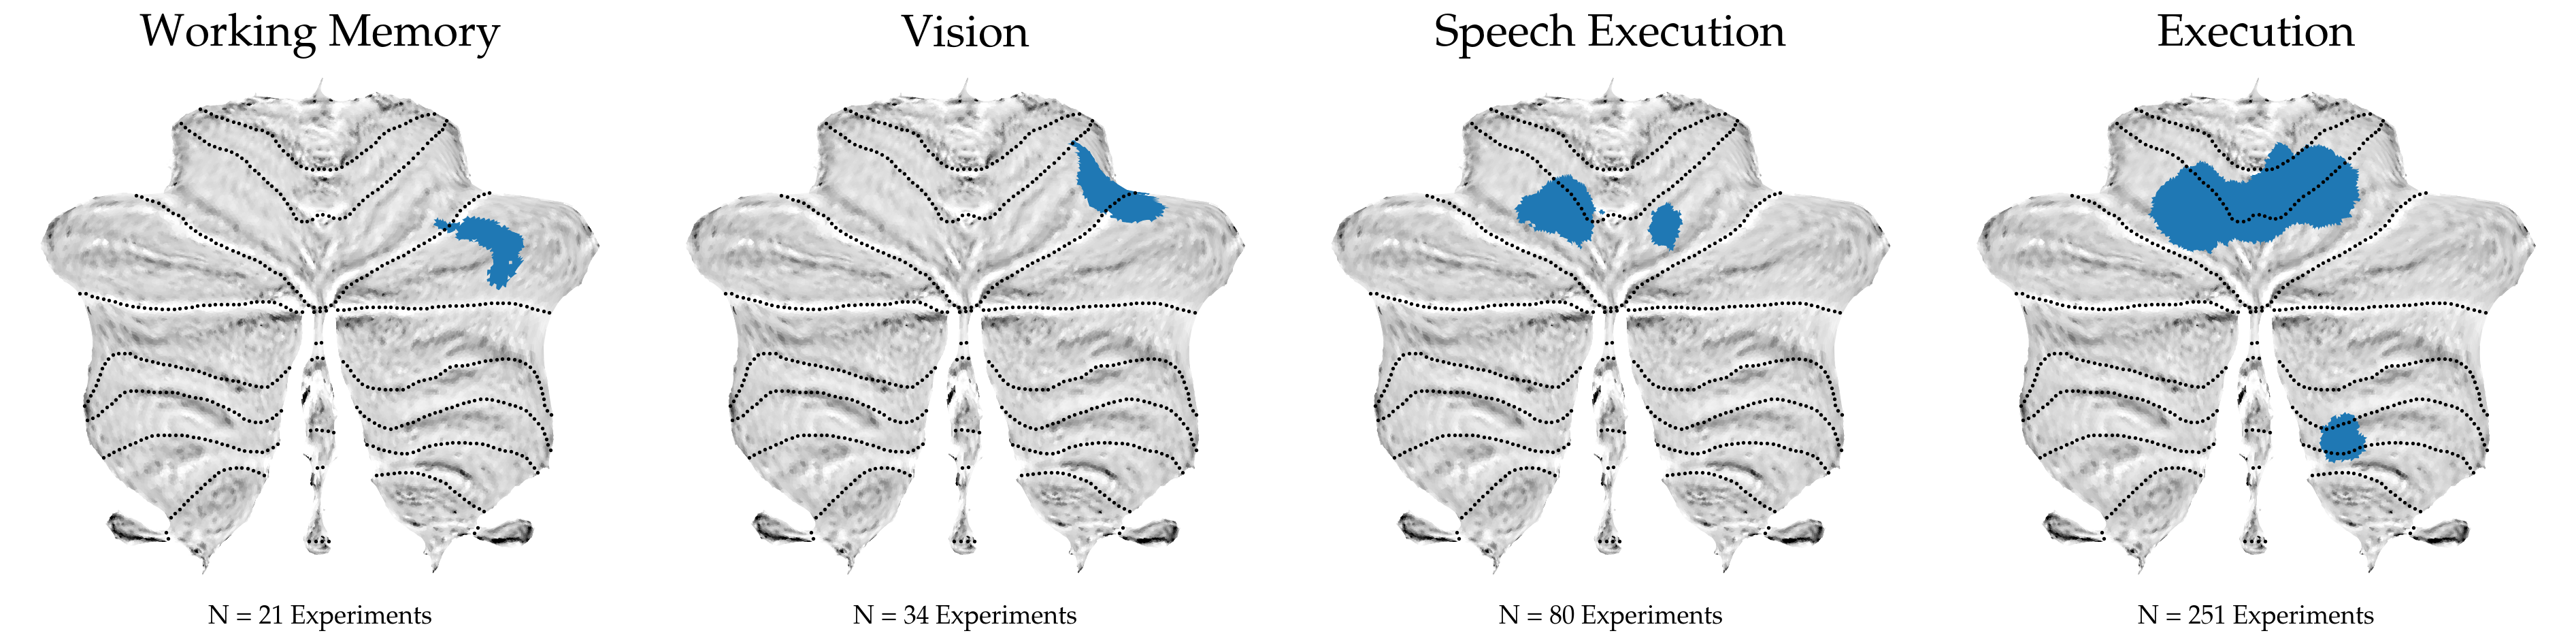

In [63]:
# 1. Cerebellar Seeds

# Define the number of rows and columns for the subplot grid
num_rows = 3
num_cols = 4
num_subdomains_to_plot = 11  # Set the number of subdomains to plot

# Order the domains based on the number of experiments
subdomain_order = pd.Series(subdomains_exps_macm).sort_values().index

# Create a new figure with the specified size
fig = plt.figure(figsize=(20, 14))

# Loop over each domain
for domain in domains:
    # Create a grid layout for subplots within the current domain's section
    grid = plt.GridSpec(num_rows, num_cols, figure=fig)

    # Loop over subdomains with both index and value
    for i, subdomain in islice(enumerate(subdomain_order), num_subdomains_to_plot):
        
        # Calculate the row and column indices within the domain's grid section
        row = i // num_cols  # Integer division to determine the row index
        col = i % num_cols   # Modulus operation to determine the column index

        # Construct the combined key for accessing the surf dictionary
        # combined_key = f"{domain}.{subdomain}"

        # Construct the file path for the current subdomain
        macm_nifti = os.path.join(OUTPUT_DIR, f'SALE/{domain}/{subdomain}/corr_cluster_k-50_z.nii.gz')

        # Check if the file path exists
        if os.path.exists(macm_nifti):
            macm_bin = nilearn.image.binarize_img(macm_nifti) # Binarize.
            # Create a subplot within the current domain's grid section
            ax = fig.add_subplot(grid[row, col])

            surface_map = SUITPy.flatmap.vol_to_surf(macm_bin, space = 'SPM').squeeze(), # Stats and space.

            surface_data = surface_map[0]  # Get the surface map data (NumPy array)
            binarized_surface_data = np.where(surface_data > 0, 1, 0) # We need to binarize again, since stats = 'nanmean' (default) averages across 6 GM depths and thus efectively removes binarization in our maps.
            
            # Plot the flatmap for the current subdomain
            SUITPy.flatmap.plot(binarized_surface_data, colorbar=False, cmap='Paired', underscale = [-0.3, 1],  new_figure=False)

            # Plot the cluster borders on top of the flatmap
            # ax.plot(cluster_borders_dict_strict[subdomain][:, 0], cluster_borders_dict_strict[subdomain][:, 1],
              #    color='black', marker='.', linestyle=None, markersize=0.5, linewidth=0)

            # Customize subplot title and text
            ax.set_title(subdomain_labels[subdomain], fontsize=25, y=1.01)
            ax.text(0.5, -0.05, f'N = {subdomains_exps_macm[subdomain]} Experiments', fontsize=14, ha='center', va='center', transform=ax.transAxes)

        else:
            print(f"File path does not exist for subdomain: {subdomain}. Skipping...")


# Adjust layout to prevent overlap
plt.tight_layout()

# Decide if you want to save the figure
fig.savefig(os.path.join(BASE_DIR, 'Figures/Publication/Figure6/Supplementary/Cerebellar_Seeds_Subd-h001_k50.png'), bbox_inches='tight')

# Show the plot
plt.show()

File path does not exist for subdomain: Cognition.Memory.Working. Skipping...
File path does not exist for subdomain: Perception.Vision. Skipping...
File path does not exist for subdomain: Perception.Vision. Skipping...
File path does not exist for subdomain: Action.Execution.Speech. Skipping...
File path does not exist for subdomain: Action.Execution. Skipping...
File path does not exist for subdomain: Cognition.Memory.Working. Skipping...
File path does not exist for subdomain: Perception.Vision. Skipping...
File path does not exist for subdomain: Action.Execution.Speech. Skipping...
File path does not exist for subdomain: Action.Execution. Skipping...
File path does not exist for subdomain: Cognition.Memory.Working. Skipping...
File path does not exist for subdomain: Perception.Vision. Skipping...
File path does not exist for subdomain: Action.Execution.Speech. Skipping...
File path does not exist for subdomain: Action.Execution. Skipping...
File path does not exist for subdomain: C

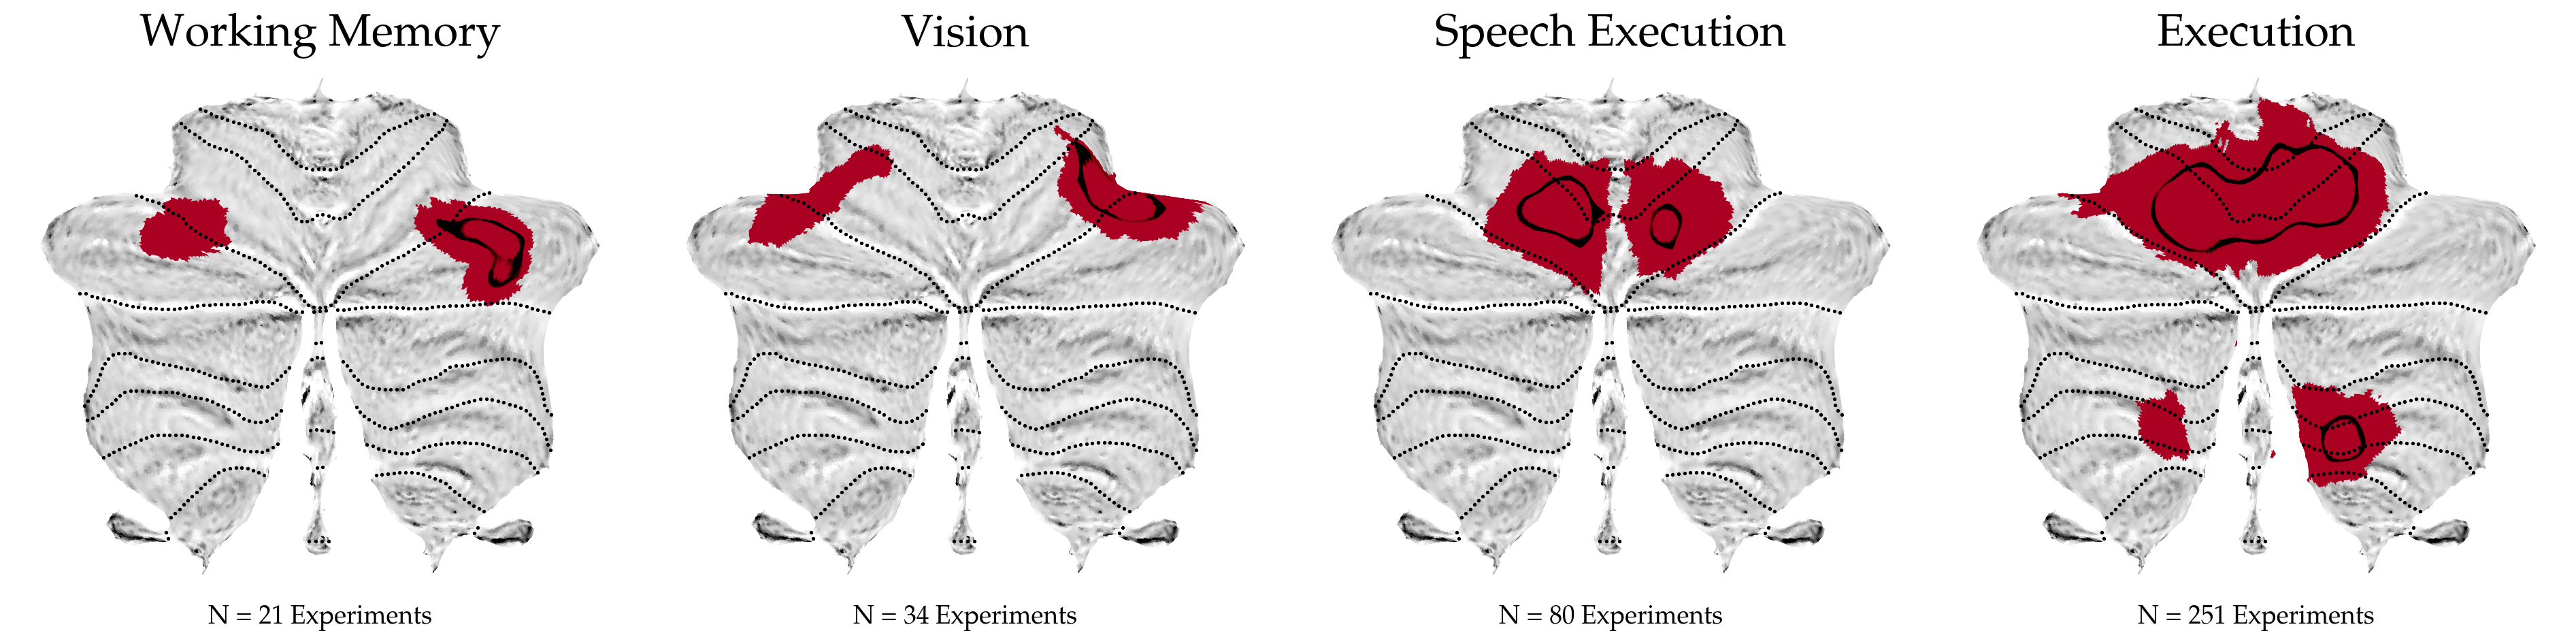

In [64]:
# 2. Cerebellar MACM results

# Define the number of rows and columns for the subplot grid
num_rows = 3
num_cols = 4
num_subdomains_to_plot = 11  # Set the number of subdomains to plot

# Order the domains based on the number of experiments
subdomain_order = pd.Series(subdomains_exps_macm).sort_values().index

# Create a new figure with the specified size
fig = plt.figure(figsize=(20, 14))

# Loop over each domain
for domain in domains:
    # Create a grid layout for subplots within the current domain's section
    grid = plt.GridSpec(num_rows, num_cols, figure=fig)

    # Loop over subdomains with both index and value
    for i, subdomain in islice(enumerate(subdomain_order), num_subdomains_to_plot):
        # Calculate the row and column indices within the domain's grid section
        row = i // num_cols  # Integer division to determine the row index
        col = i % num_cols   # Modulus operation to determine the column index

        # Construct the combined key for accessing the surf dictionary
        # combined_key = f"{domain}.{subdomain}"
        
        # Construct the file path for the current subdomain
        macm_nifti = os.path.join(OUTPUT_DIR, f'SALE/{domain}/{subdomain}/corr_cluster_h-001_k-50_mask-D2009_MNI_z_macm/corr_cluster_k-50_z.nii.gz')

        # Check if the file path exists
        if os.path.exists(macm_nifti):
            macm_bin = nilearn.image.binarize_img(macm_nifti) # Binarize.
            # Create a subplot within the current domain's grid section
            ax = fig.add_subplot(grid[row, col])

            surface_map = SUITPy.flatmap.vol_to_surf(macm_bin, space = 'SPM').squeeze(), # Stats and space.

            # Overlay the cluster borders on top
            ax.plot(cluster_borders_dict_strict[subdomain][:, 0], cluster_borders_dict_strict[subdomain][:, 1], # Add borders if desired.
                    color='black', marker='.', linestyle=None, markersize=0.01, linewidth=0)
            

            surface_data = surface_map[0]  # Get the surface map data (NumPy array)
            binarized_surface_data = np.where(surface_data > 0, 1, 0) # We need to binarize again, since stats = 'nanmean' (default) averages across 6 GM depths and thus efectively removes binarization in our maps.
            
            # Plot the flatmap for the current subdomain
            SUITPy.flatmap.plot(binarized_surface_data, colorbar=False, cmap=custom_cmap, underscale = [-0.3, 1],  new_figure=False)

            # Customize subplot title and text
            ax.set_title(subdomain_labels[subdomain], fontsize=25, y=1.01)
            ax.text(0.5, -0.05, f'N = {subdomains_exps_macm[subdomain]} Experiments', fontsize=14, ha='center', va='center', transform=ax.transAxes)

        else:
            print(f"File path does not exist for subdomain: {subdomain}. Skipping...")


# Adjust layout to prevent overlap
plt.tight_layout()

# Decide if you want to save the figure
fig.savefig(os.path.join(BASE_DIR, 'Figures/Publication/Figure6/6b_Cerebellum_MACM-Subd-h001_k50_Figure_wborders'), bbox_inches='tight')

# Show the plot
plt.show()

File path does not exist for subdomain: Cognition.Memory.Working. Skipping...
File path does not exist for subdomain: Perception.Vision. Skipping...
File path does not exist for subdomain: Perception.Vision. Skipping...
File path does not exist for subdomain: Action.Execution.Speech. Skipping...
File path does not exist for subdomain: Action.Execution. Skipping...
File path does not exist for subdomain: Cognition.Memory.Working. Skipping...
File path does not exist for subdomain: Perception.Vision. Skipping...
File path does not exist for subdomain: Action.Execution.Speech. Skipping...
File path does not exist for subdomain: Action.Execution. Skipping...
File path does not exist for subdomain: Cognition.Memory.Working. Skipping...
File path does not exist for subdomain: Perception.Vision. Skipping...
File path does not exist for subdomain: Action.Execution.Speech. Skipping...
File path does not exist for subdomain: Action.Execution. Skipping...
File path does not exist for subdomain: C

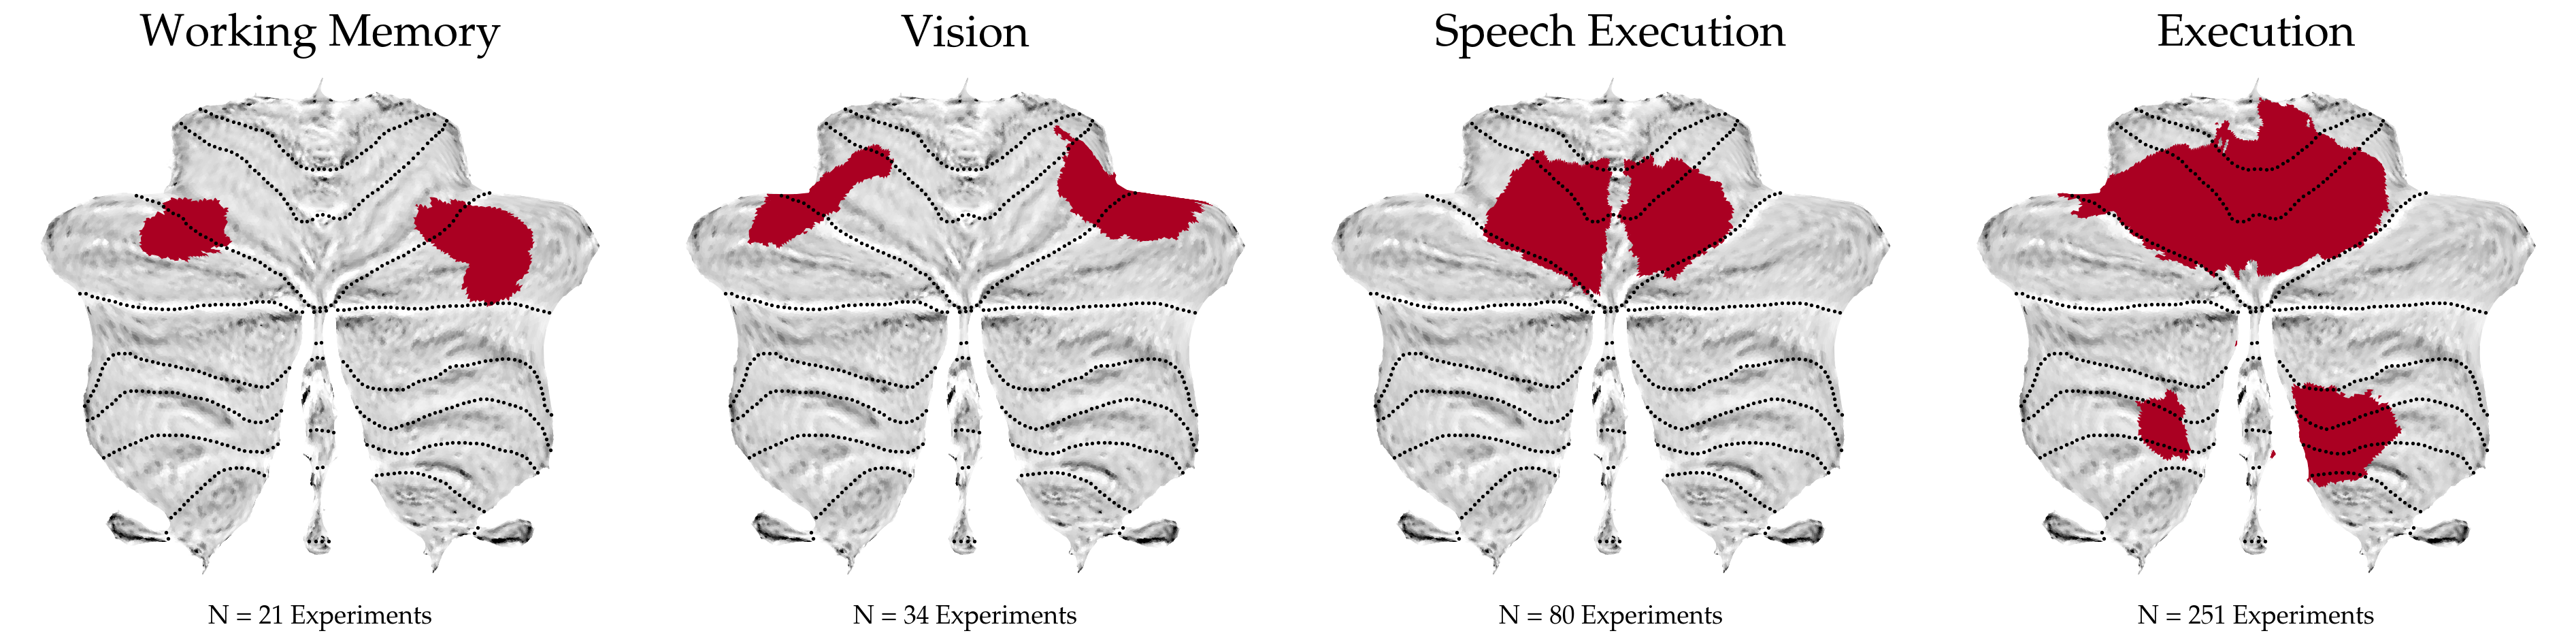

In [65]:
# 2. Cerebellar MACM results (but without overlay)

# Define the number of rows and columns for the subplot grid
num_rows = 3
num_cols = 4
num_subdomains_to_plot = 11  # Set the number of subdomains to plot

# Order the domains based on the number of experiments
subdomain_order = pd.Series(subdomains_exps_macm).sort_values().index

# Create a new figure with the specified size
fig = plt.figure(figsize=(20, 14))

# Loop over each domain
for domain in domains:
    # Create a grid layout for subplots within the current domain's section
    grid = plt.GridSpec(num_rows, num_cols, figure=fig)

    # Loop over subdomains with both index and value
    for i, subdomain in islice(enumerate(subdomain_order), num_subdomains_to_plot):
        # Calculate the row and column indices within the domain's grid section
        row = i // num_cols  # Integer division to determine the row index
        col = i % num_cols   # Modulus operation to determine the column index

        # Construct the combined key for accessing the surf dictionary
        # combined_key = f"{domain}.{subdomain}"
        
        # Construct the file path for the current subdomain
        macm_nifti = os.path.join(OUTPUT_DIR, f'SALE/{domain}/{subdomain}/corr_cluster_h-001_k-50_mask-D2009_MNI_z_macm/corr_cluster_k-50_z.nii.gz')

        # Check if the file path exists
        if os.path.exists(macm_nifti):
            macm_bin = nilearn.image.binarize_img(macm_nifti) # Binarize.
            # Create a subplot within the current domain's grid section
            ax = fig.add_subplot(grid[row, col])

            surface_map = SUITPy.flatmap.vol_to_surf(macm_bin, space = 'SPM').squeeze(), # Stats and space.

            surface_data = surface_map[0]  # Get the surface map data (NumPy array)
            binarized_surface_data = np.where(surface_data > 0, 1, 0) # We need to binarize again, since stats = 'nanmean' (default) averages across 6 GM depths and thus efectively removes binarization in our maps.
            
            # Plot the flatmap for the current subdomain
            SUITPy.flatmap.plot(binarized_surface_data, colorbar=False, cmap=custom_cmap, underscale = [-0.3, 1],  new_figure=False)

            # Customize subplot title and text
            ax.set_title(subdomain_labels[subdomain], fontsize=25, y=1.01)
            ax.text(0.5, -0.05, f'N = {subdomains_exps_macm[subdomain]} Experiments', fontsize=14, ha='center', va='center', transform=ax.transAxes)

        else:
            print(f"File path does not exist for subdomain: {subdomain}. Skipping...")


# Adjust layout to prevent overlap
plt.tight_layout()

# Decide if you want to save the figure
fig.savefig(os.path.join(BASE_DIR, 'Figures/Publication/Figure6/Supplementary/Cerebellum_MACM-Subd-h001_k50_Figure_woborders'), bbox_inches='tight')

# Show the plot
plt.show()

# 3. Subcortical results

100%|████████████████████████████████████████████████████████████████████| 12/12 [00:15<00:00,  1.28s/it]


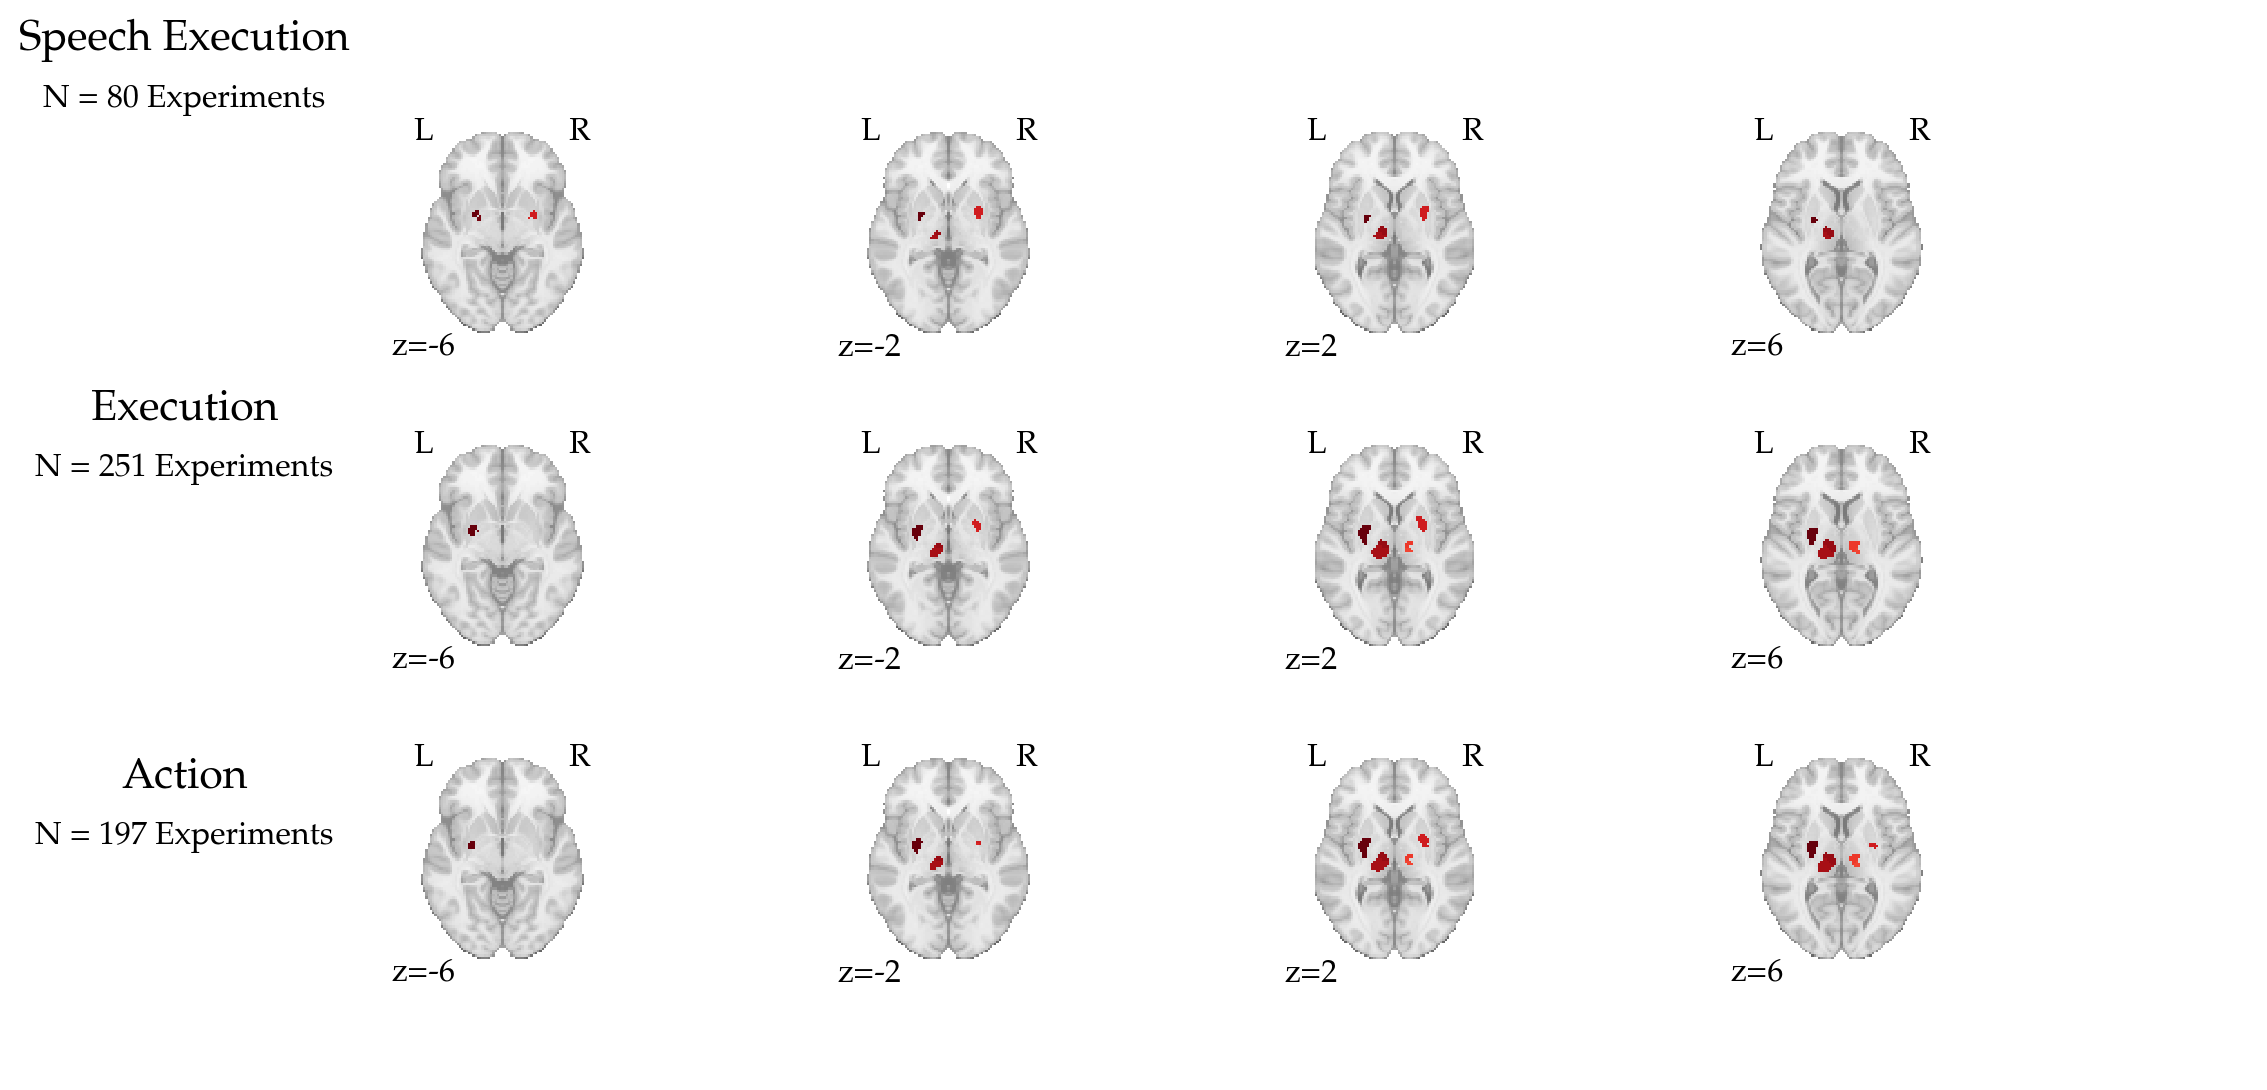

In [66]:
# Load and resample the Tian subcortical parcellation
tian = nibabel.load(os.path.join(INPUT_DIR, 'maps/Tian_Subcortex_S1_3T.nii'))
mask = nibabel.load(os.path.join(INPUT_DIR, 'maps/Grey10.nii.gz'))
tian_2mm = nilearn.image.resample_to_img(tian, mask)

# Get MACM paths
macm_paths = sorted(glob.glob(
    '/data/project/cerebellum_ale/output/SALE/*/*/corr_cluster_h-001_k-50_mask-D2009_MNI_z_macm/corr_cluster_k-50_z.nii.gz'
))

# Create an empty list to store valid MACM maps
valid_macm_maps = []

# Loop over all MACM maps to plot them
for i, macm_path in enumerate(tqdm(macm_paths)):
    # Extract the subdomain name
    subbd = (macm_path
             .split('/corr_cluster_h-001_k-50_mask-D2009_MNI_z_macm/corr_cluster_k-50_z.nii.gz')[0]
             .split('/data/project/cerebellum_ale/output/SALE/')[1]
             .split('/')[1]
            )
    
    # Load the MACM map
    macm_img = nilearn.image.load_img(macm_path)
    
    # Binarize it
    macm_bin = nilearn.image.binarize_img(macm_img)
    
    # Apply the subcortex mask to the binarized MACM map (effectively restricting the MACM map to the subcortex)
    macm_bin_crop = nilearn.image.math_img('img1 * img2', img1=macm_bin, img2=tian_2mm)
    
    # Convert the cropped MACM map to a numpy array and check if there is any data in there
    macm_bin_crop_data = macm_bin_crop.get_fdata()
    if np.any(macm_bin_crop_data):  # Only plot if there is data
        
        # Add valid maps + their subdomain name to the list
        valid_macm_maps.append((macm_bin_crop, subbd))

# Determine the number of valid plots and create the figure
n_plots = len(valid_macm_maps)
n_cols = 1  # Number of columns (adjust as needed)
n_rows = int(np.ceil(n_plots / n_cols))

fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 6))
axes = axes.flatten()  # Flatten the axes array for easy indexing
        
# Plot the valid MACM maps
for i, (macm_bin_crop, subbd) in enumerate(valid_macm_maps):
    # Get the nicer label for the current subdomain
    label = subdomain_labels.get(subbd, subbd)
    
    # Plot the MACM map on the corresponding subplot
    nilearn.plotting.plot_stat_map(
        macm_bin_crop, 
        cmap='Reds', 
        display_mode='z', 
        cut_coords=[-6, -2, 2, 6],  # Adjust the slices as needed
        title=None,  # Disable the title in plot_stat_map
        axes=axes[i],
        colorbar=False
    )
    
    # Set the title using Matplotlib to avoid the black box background
    axes[i].set_title(f"{label}", size=16, x= -0.15, y=1.20, fontweight='bold')

    # Add text label for the sample size
    num_experiments = both_exps_macm.get(subbd, 'N/A')
    axes[i].text(-0.15, 1.05, f'N = {num_experiments} Experiments', fontsize=12, ha='center', va='center', transform=axes[i].transAxes)

# Remove any empty subplots if the number of valid maps is less than the grid size
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Adjust layout and save the figure
plt.tight_layout()
plt.savefig(os.path.join(BASE_DIR, f'Figures/Publication/Figure6/6c_Subcortex_MACM-Subd-h001_k50_Figure.png'), bbox_inches='tight', dpi=300)

plt.show()


# 4. Cerebral results

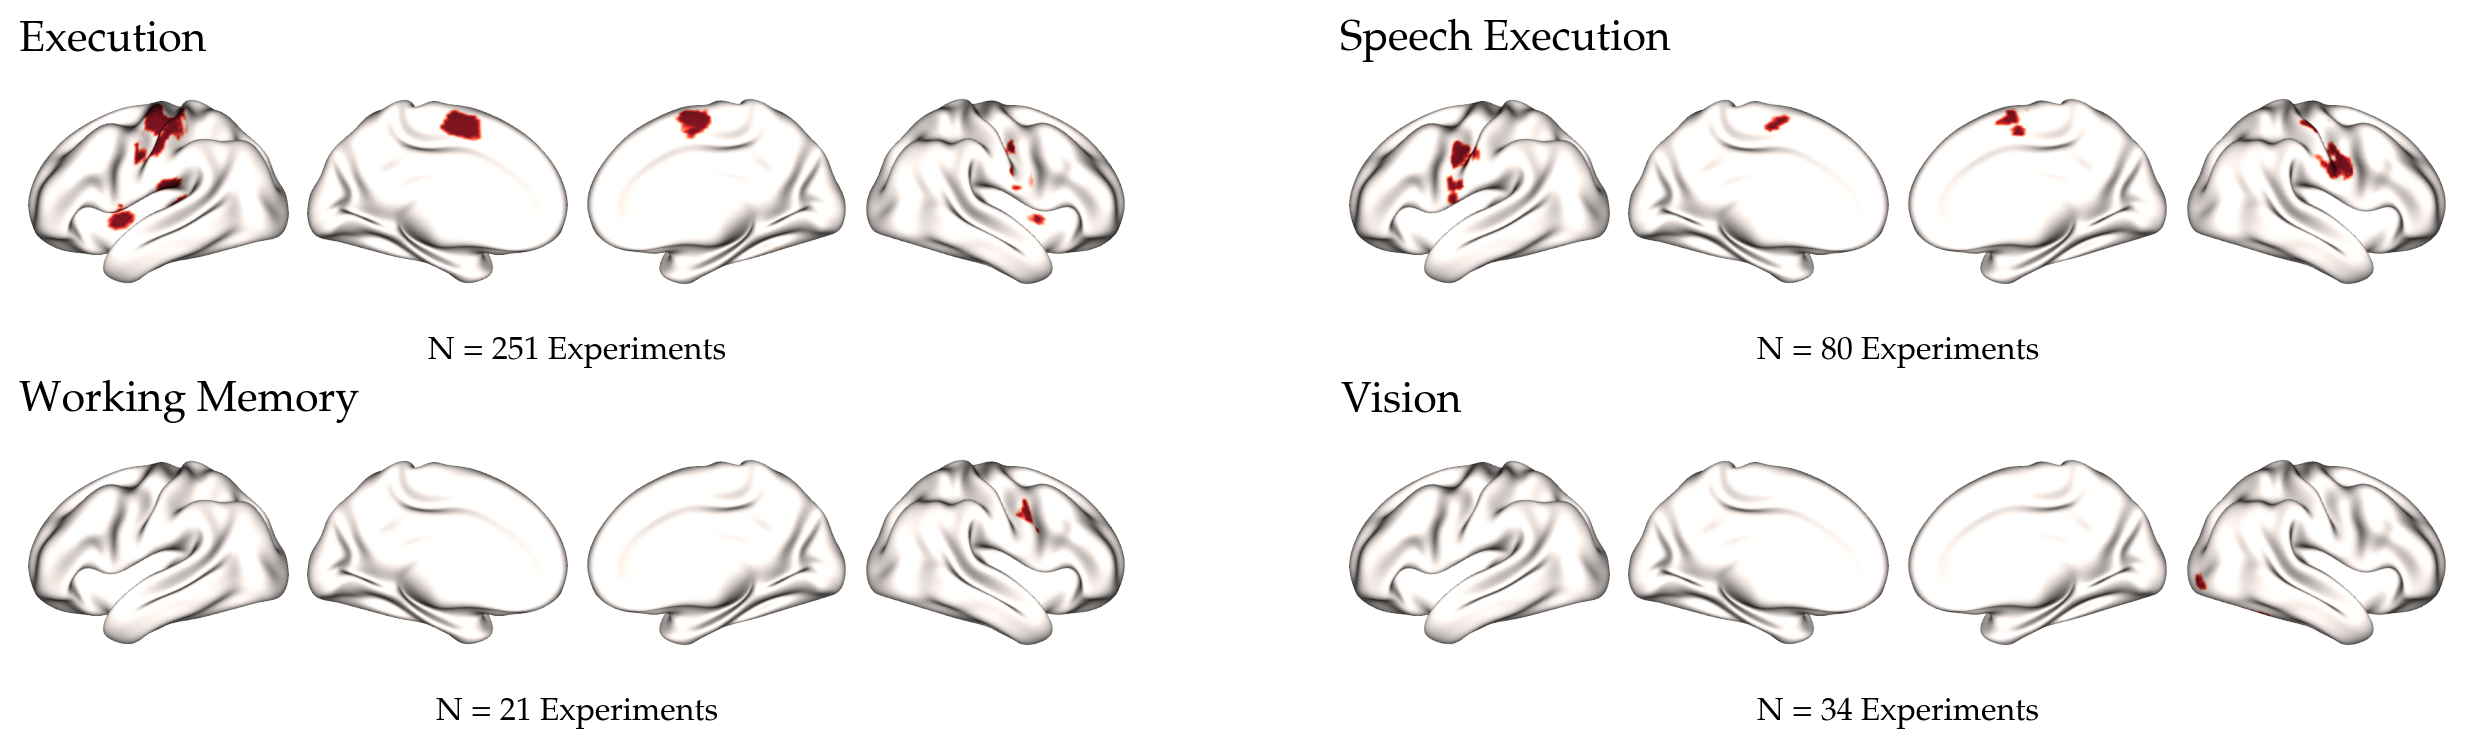

In [72]:
# Define the base directory and file pattern for subdomain plots
base_dir_figures = os.path.join(BASE_DIR, 'Figures/Publication/Figure6/Cerebrum')
file_pattern = '{domain}.{subdomain}/{subdomain}_MACM_Cerebral-Cortex-Surface_p001_K50-binarized.png'

# Define domains and subdomains here, if you have not yet.
domains = ['Action', 'Cognition', 'Emotion', 'Interoception', 'Perception']
subdomains = ['Execution', 'Execution.Speech', 'Imagination', 'Inhibition', 'MotorLearning', 'Observation', 'Preparation', 'Attention', 'Language', 'Language.Orthography', 'Language.Phonology', 'Language.Semantics', 'Language.Speech', 'Language.Syntax','Memory', 'Memory.Explicit', 'Memory.Working','Music', 'Reasoning', 'SocialCognition', 'Spatial', 'Temporal', 'Negative', 'Negative.Anger', 'Negative.Anxiety', 'Negative.Disgust', 'Negative.Fear', 'Negative.Sadness', 'Positive', 'Positive.Happiness', 'Positive.RewardGain', 'Valence', 'Hunger', 'RespirationRegulation', 'Sexuality', 'Audition', 'Gustation', 'Olfaction', 'Somesthesis', 'Somesthesis.Pain','Vision', 'Vision.Color','Vision.Motion', 'Vision.Shape']

subdomain_label_map = {
    'Action.MotorLearning': 'Motor Learning',
    'Action.Observation': 'Observation',
    'Action.Execution.Speech': 'Speech Execution',
    'Action.Inhibition': 'Inhibition',
    'Action.Execution': 'Execution',
    'Action.Preparation': 'Preparation',
    'Action.Imagination': 'Imagination',
    'Action': 'Action',
    'Cognition.Spatial': 'Spatial',
    'Cognition.SocialCognition': 'Social Cognition',
    'Cognition.Attention': 'Attention',
    'Cognition.Language.Syntax': 'Syntax',
    'Cognition.Memory': 'Memory',
    'Cognition.Memory.Explicit': 'Explicit Memory',
    'Cognition.Language': 'Language',
    'Cognition.Language.Semantics': 'Semantics',
    'Cognition.Memory.Working': 'Working Memory',
    'Cognition.Language.Phonology': 'Phonology',
    'Cognition.Reasoning': 'Reasoning',
    'Cognition.Temporal': 'Temporal',
    'Cognition.Language.Speech': 'Speech',
    'Cognition.Language.Orthography': 'Orthography',
    'Cognition.Music': 'Music',
    'Emotion.Positive.RewardGain': 'Reward/ Gain',
    'Emotion.Negative.Disgust': 'Disgust',
    'Emotion.Positive': 'Positive Emotion',
    'Emotion.Negative.Fear': 'Fear',
    'Emotion.Positive.Happiness': 'Happiness',
    'Emotion.Negative.Sadness': 'Sadness',
    'Emotion.Negative': 'Negative Emotion',
    'Emotion.Valence': 'Valence',
    'Emotion.Negative.Anger': 'Anger',
    'Emotion.Negative.Anxiety': 'Anxiety',
    'Perception.Vision': 'Vision',
    'Perception.Olfaction': 'Olfaction',
    'Perception.Vision.Motion': 'Vision - Motion',
    'Perception.Gustation': 'Gustation',
    'Perception.Somesthesis.Pain': 'Pain',
    'Perception.Audition': 'Audition',
    'Perception.Somesthesis': 'Somesthesis',
    'Perception.Vision.Color': 'Vision - Color',
    'Perception.Vision.Shape': 'Vision - Shape',
    'Interoception.Sexuality': 'Sexuality',
    'Interoception.RespirationRegulation': 'Respiration Regulation',
    'Interoception.Hunger': 'Hunger'
}

# Collect all valid plot file paths and prepare corresponding labels
plot_files = []
plot_labels = []
sample_size_keys = []  # This will hold keys to be used for fetching sample sizes

for domain in domains:
    for subdomain in subdomains:
        plot_path = os.path.join(base_dir_figures, file_pattern.format(domain=domain, subdomain=subdomain))
        if os.path.exists(plot_path):
            plot_files.append(plot_path)
            
            # Create the full label using the subdomain_label_map
            full_label = f"{domain}.{subdomain}"
            nice_label = subdomain_label_map.get(full_label, subdomain)
            plot_labels.append(nice_label)
            
            # Create the corresponding key for both_exps_macm
            # Convert the full label to the correct format by replacing spaces with periods
            sample_size_key = full_label.replace(' ', '.')
            sample_size_keys.append(sample_size_key)

# Determine the number of valid plots
n_plots = len(plot_files)

# Set up the figure size and create subplots
n_cols = 2  # Adjust columns based on your preference
n_rows = int(np.ceil(n_plots / n_cols))
fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(14, 2 * n_rows))
axes = axes.flatten()

# Loop through the plot files and assign them to axes
for i, (plot_file, label, sample_key) in enumerate(zip(plot_files, plot_labels, sample_size_keys)):
    # Load the image and display it in the corresponding Matplotlib axis
    img = plt.imread(plot_file)
    axes[i].imshow(img)
    axes[i].axis('off')  # Hide axis

    # Get the sample size from both_exps_macm using the sample_key
    num_experiments = both_exps_macm.get(sample_key, 'N/A')

    # Set the title for each subplot using the nicer label and sample size
    axes[i].set_title(f"{label}", size=16, loc='left', y=0.95, fontweight='bold')
    # Set the title for each subplot using the nicer label and sample size
    axes[i].text(0.5, -0.1, f"N = {num_experiments} Experiments", size=12, ha='center', transform=axes[i].transAxes, fontweight='bold')
    
# Remove any empty subplots if the number of valid maps is less than the grid size
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Adjust layout and save the figure
plt.tight_layout()
plt.savefig(os.path.join(BASE_DIR, 'Figures/Publication/Figure6/6d_Cerebrum_MACM-Subd-h001_k50_Figure.png'), bbox_inches='tight', dpi=300)

plt.show()


# The End.